In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

from spacepy import pycdf

# Configure Matplotlib

Choose a matplotlib style sheet to match your browser theme (dark or light)

Increase the figure size to match the notebook width.

Set the graph colour variables.

In [2]:
#style_sheet = 'dark_background' # dark theme
style_sheet = 'default'         # light theme
plt.style.use(style_sheet)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

dsc_colour = 'green'
wnd_colour = 'magenta'
anl_colour = 'red'

In [3]:
WND_MFI_DIR = 'data/raw/WIND/mfi/2022'
wnd_mfi_sample = 'wi_h2_mfi_20220514_v04.cdf'
xwnd_filename = os.path.join(WND_MFI_DIR, wnd_mfi_sample)
cdf_xwnd = pycdf.CDF(xwnd_filename)
wnd_B = cdf_xwnd['BGSE']
wnd_t = cdf_xwnd['Time_PB5']
print("WIND MFI B shape:",wnd_B.shape)
print("WIND MFI Time_PB5 shape:",wnd_t.shape)

WIND MFI B shape: (935602, 3)
WIND MFI Time_PB5 shape: (935602, 3)


In [4]:
DSC_MFI_DIR = 'data/raw/DSCVR/mfi/2022'
wnd_mfi_sample = 'wi_h2_mfi_20220514_v04.cdf'
xdsc_filename = os.path.join(DSC_MFI_DIR,'dscovr_h0_mag_20220514_v01.cdf')
cdf_xdsc = pycdf.CDF(xdsc_filename)
dsc_B = cdf_xdsc['B1GSE']
dsc_t = cdf_xdsc['Time1_PB5']
print("DSCVR MFI B shape:",dsc_B.shape)
print("DSCVR MFI Time1_PB5 shape:",dsc_t.shape)

DSCVR MFI B shape: (86400, 3)
DSCVR MFI Time1_PB5 shape: (86400, 3)


We will take a quick look at 1 day of WIND and DSCVR magnetic field data (same day).

In [5]:
start = 0
stop = 86400
time_steps = np.linspace(start, stop, num=stop-start, endpoint=False)
wnd_t_ix = np.rint(time_steps * 10.828726851851853 + 5).astype(int)
print(wnd_t_ix[0:10])

[  5  16  27  37  48  59  70  81  92 102]


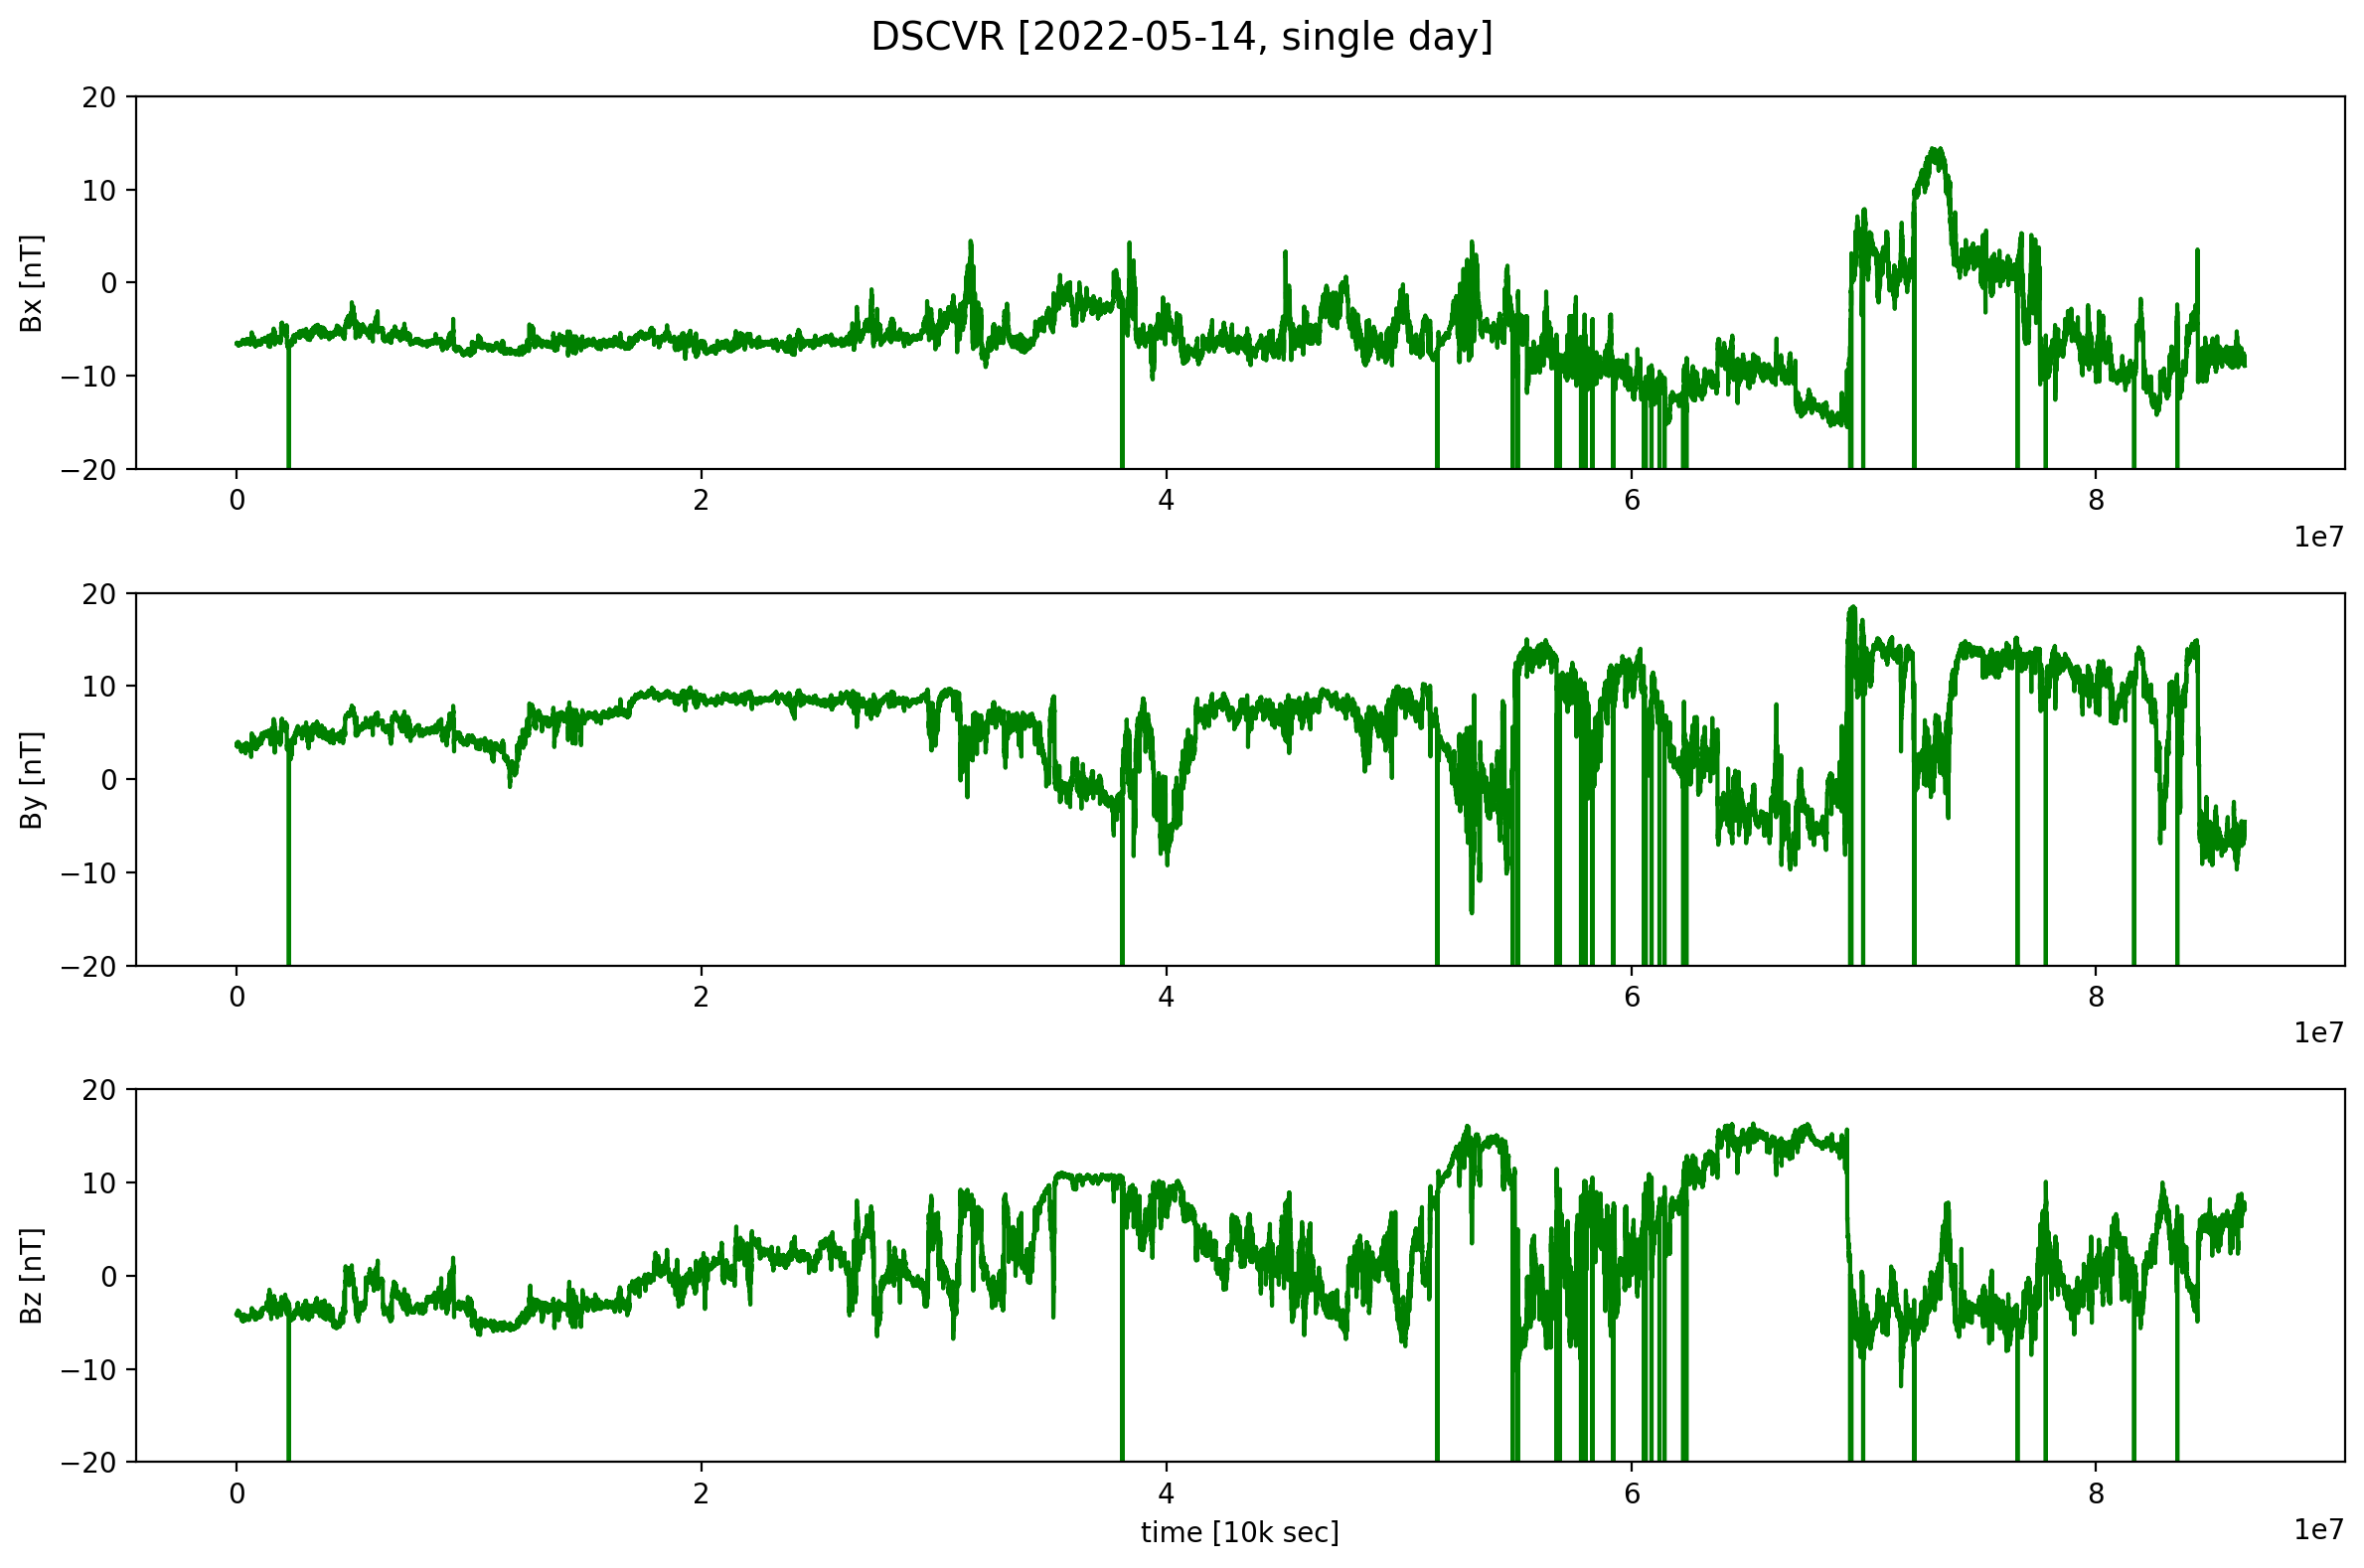

In [6]:
fig, axs = plt.subplots(3, 1)
title = 'DSCVR [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

d_t = np.asarray(dsc_t[:,:])
d_b = np.asarray(dsc_B[:,:])

d_bx, = axs[0].plot(dsc_t[:,2], dsc_B[:,0], color=dsc_colour, label='Bx')
d_by, = axs[1].plot(dsc_t[:,2], dsc_B[:,1], color=dsc_colour, label='By')
d_bz, = axs[2].plot(dsc_t[:,2], dsc_B[:,2], color=dsc_colour, label='Bz')

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

axs[0].set(ylim=(-20,20))
axs[1].set(ylim=(-20,20))
axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

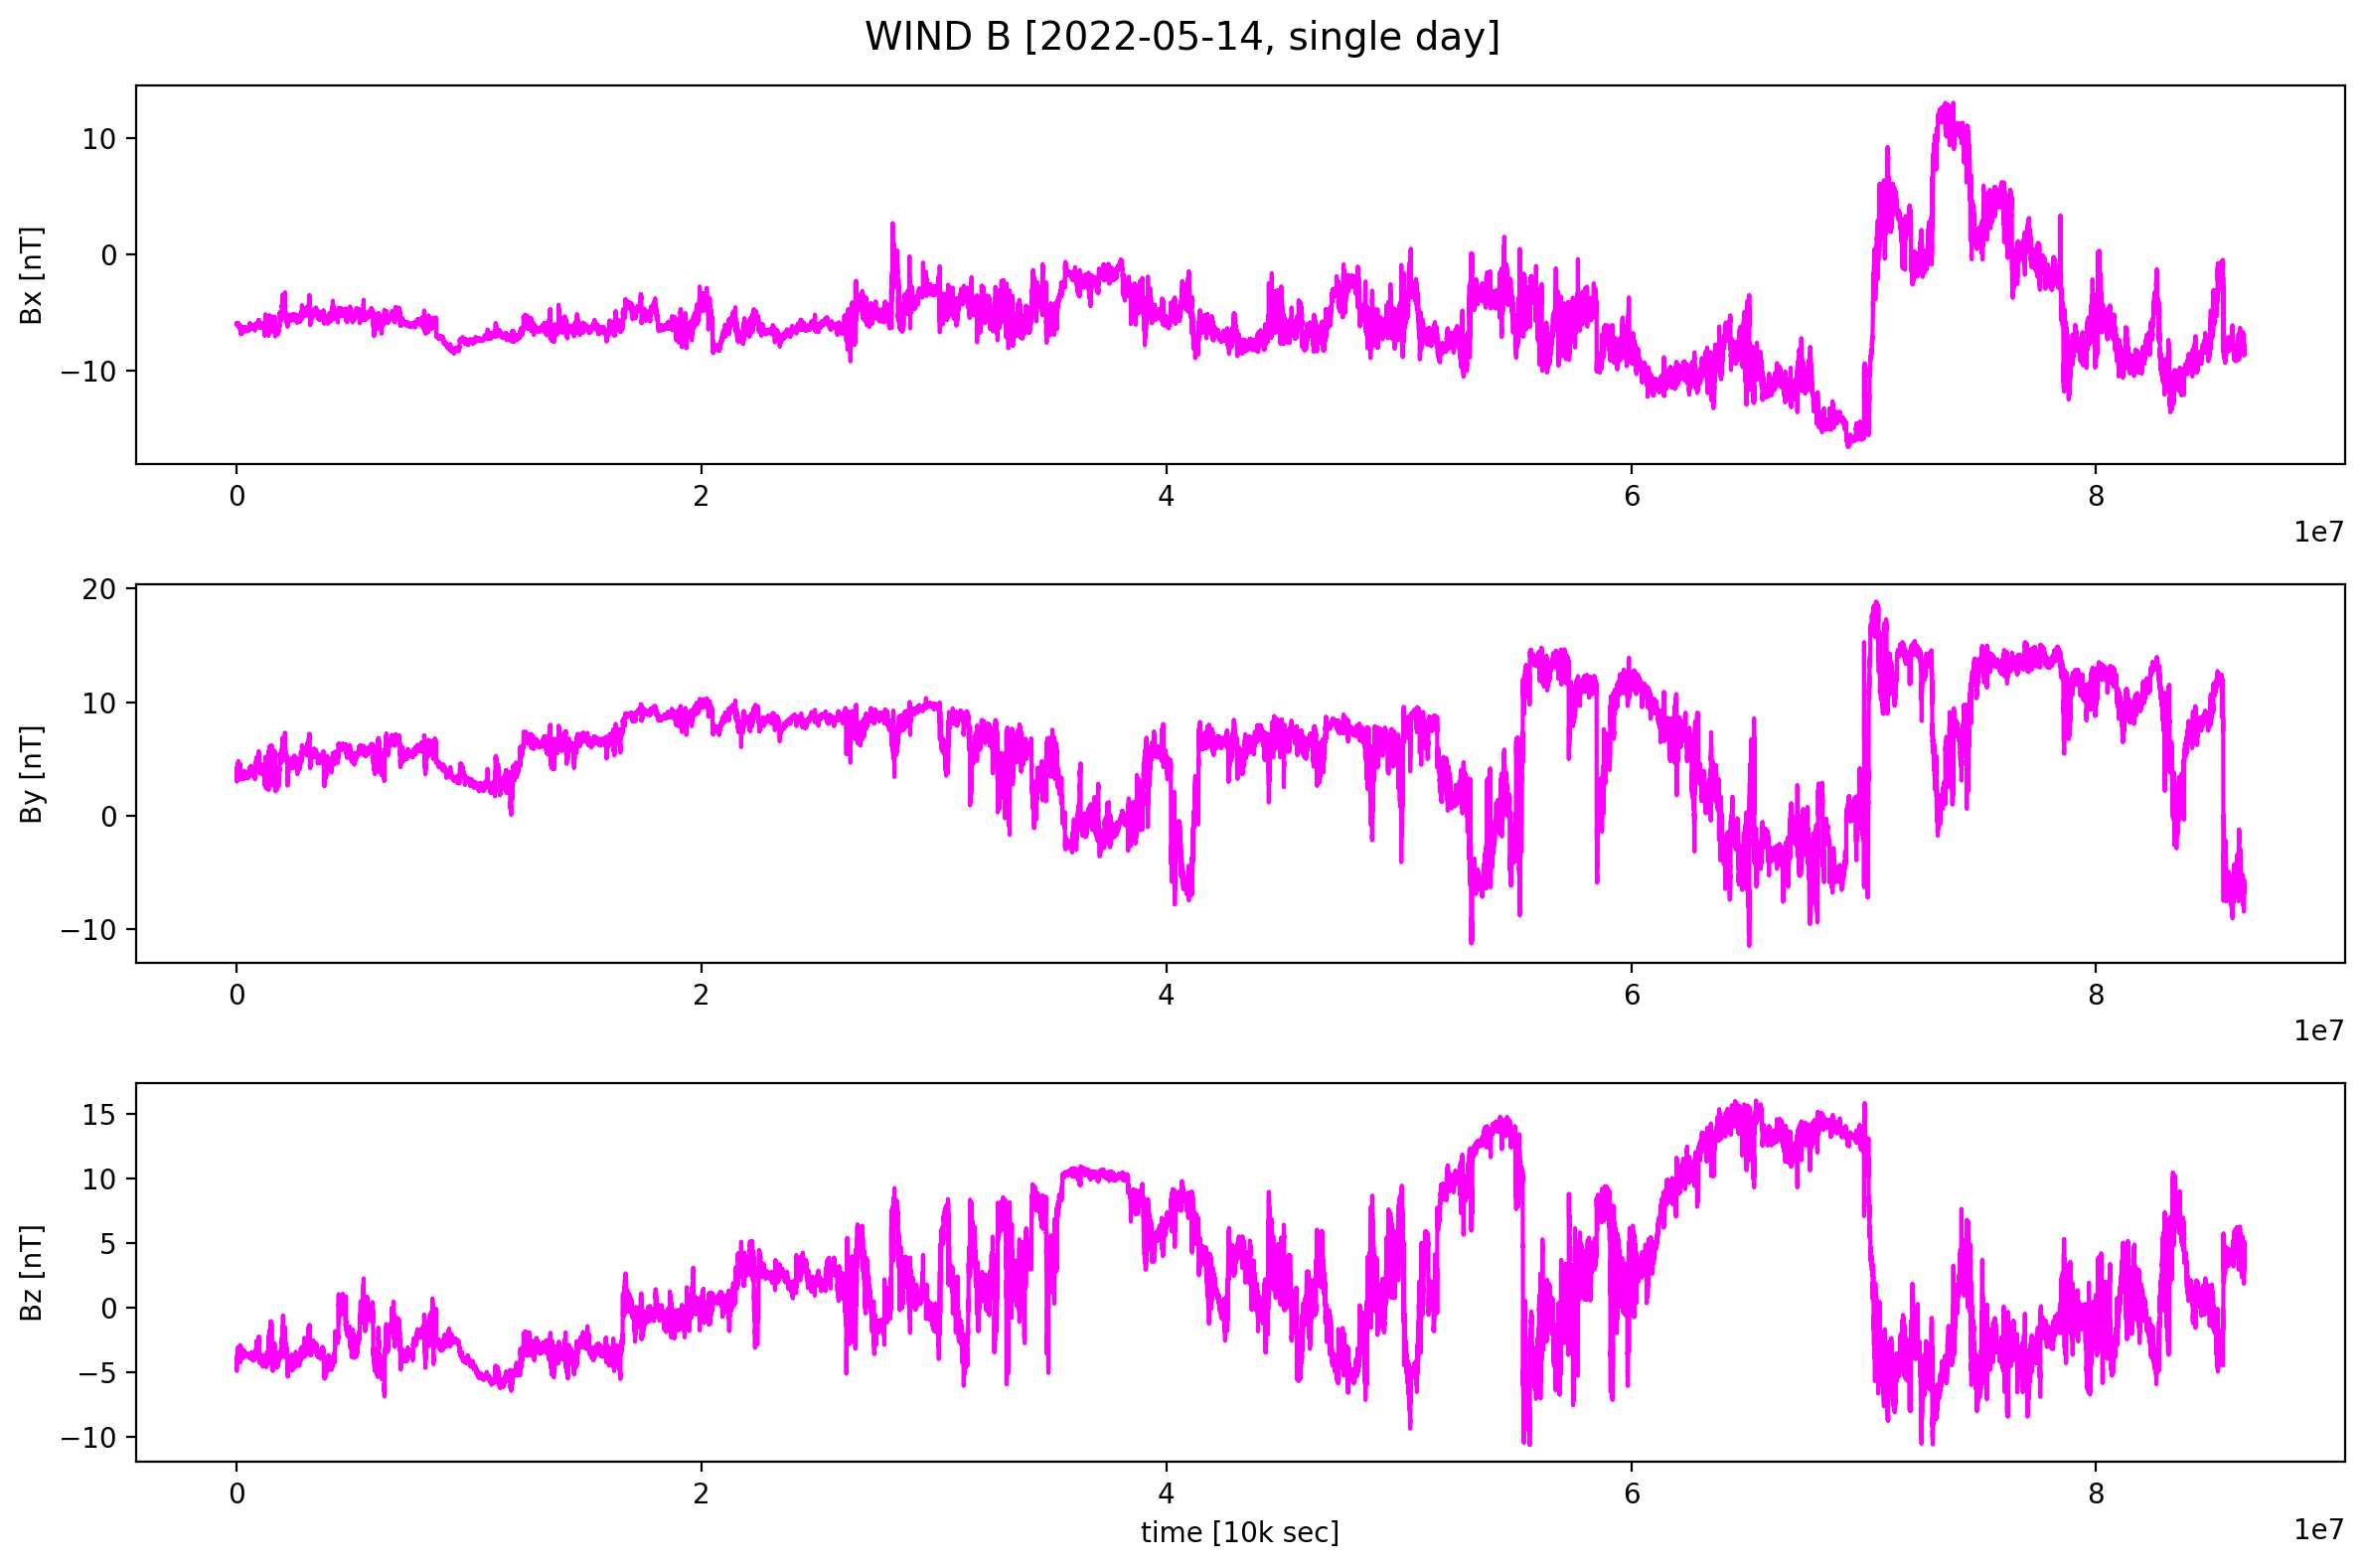

In [7]:
fig, axs = plt.subplots(3, 1)
title = 'WIND B [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

w_t = np.asarray(wnd_t[:,:])
w_b = np.asarray(wnd_B[:,:])

w_bx, = axs[0].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')
w_by, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')
w_bz, = axs[2].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

#axs[0].set(ylim=(-20,20))
#axs[1].set(ylim=(-20,20))
#axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

In [8]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = w_b.mean()
training_std = w_b.std()
df_training_value = (w_b[wnd_t_ix]  - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 86400


# Time Conversion functions

Let's define some helper functions to convert some time formats into human readable time

In [9]:
def time_from_seconds(seconds):
  seconds = seconds % (24 * 3600)
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
     
  return "%d:%02d:%02d" % (hour, minutes, seconds)

def time_from_doy(doy):
  part, whole = np.modf(doy)
  seconds = part * 86400
     
  return time_from_seconds(seconds)

def date_from_yeardoy(year, doy):
  part, whole = np.modf(doy)
  datestr = "%4d-%03.0f"%(year, whole)
  # converting to date
  unix_dt = datetime.strptime(datestr, "%Y-%j")
  res = unix_dt.strftime("%Y-%m-%d")
  return res

In [10]:
timestamp_str = "%s %s" %(date_from_yeardoy(2020,339.04167),time_from_doy(339.04167))
print("2020 339.04167 days:", timestamp_str)

2020 339.04167 days: 2020-12-04 1:00:00


In [11]:
date_1 = '1994-01-01 00:00:00'
date_2 = timestamp_str
date_format_str = '%Y-%m-%d %H:%M:%S'
start = datetime.strptime(date_1, date_format_str)
end =   datetime.strptime(date_2, date_format_str)
# Get the interval between two datetimes as timedelta object
diff = end - start
print('Difference between two datetimes in seconds:')
print(diff.total_seconds())

Difference between two datetimes in seconds:
849661200.0


In [12]:
TIME_STEPS = 300

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (86101, 300, 3)


In [13]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        #layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        #layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=3, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 150, 32)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 150, 16)           1808      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 300, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 300, 3)            675       
Total params: 10,403
Trainable params: 10,403
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0731 - val_loss: 0.0072
Epoch 2/50
303/303 [==============================] - 8s 25ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 3/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 4/50
303/303 [==============================] - 8s 25ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 5/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 7/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 8/50
303/303 [==============================] - 8s 25ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0012 - val_lo

In [15]:
#model.save("aw_bs256_lr1e-3_do0_v1")
model=load_model("aw_bs256_lr1e-3_do0_v1")
#model.save("aw_bs256_lr1e-3_do0")
#model=load_model("aw_bs256_lr1e-3_do0")

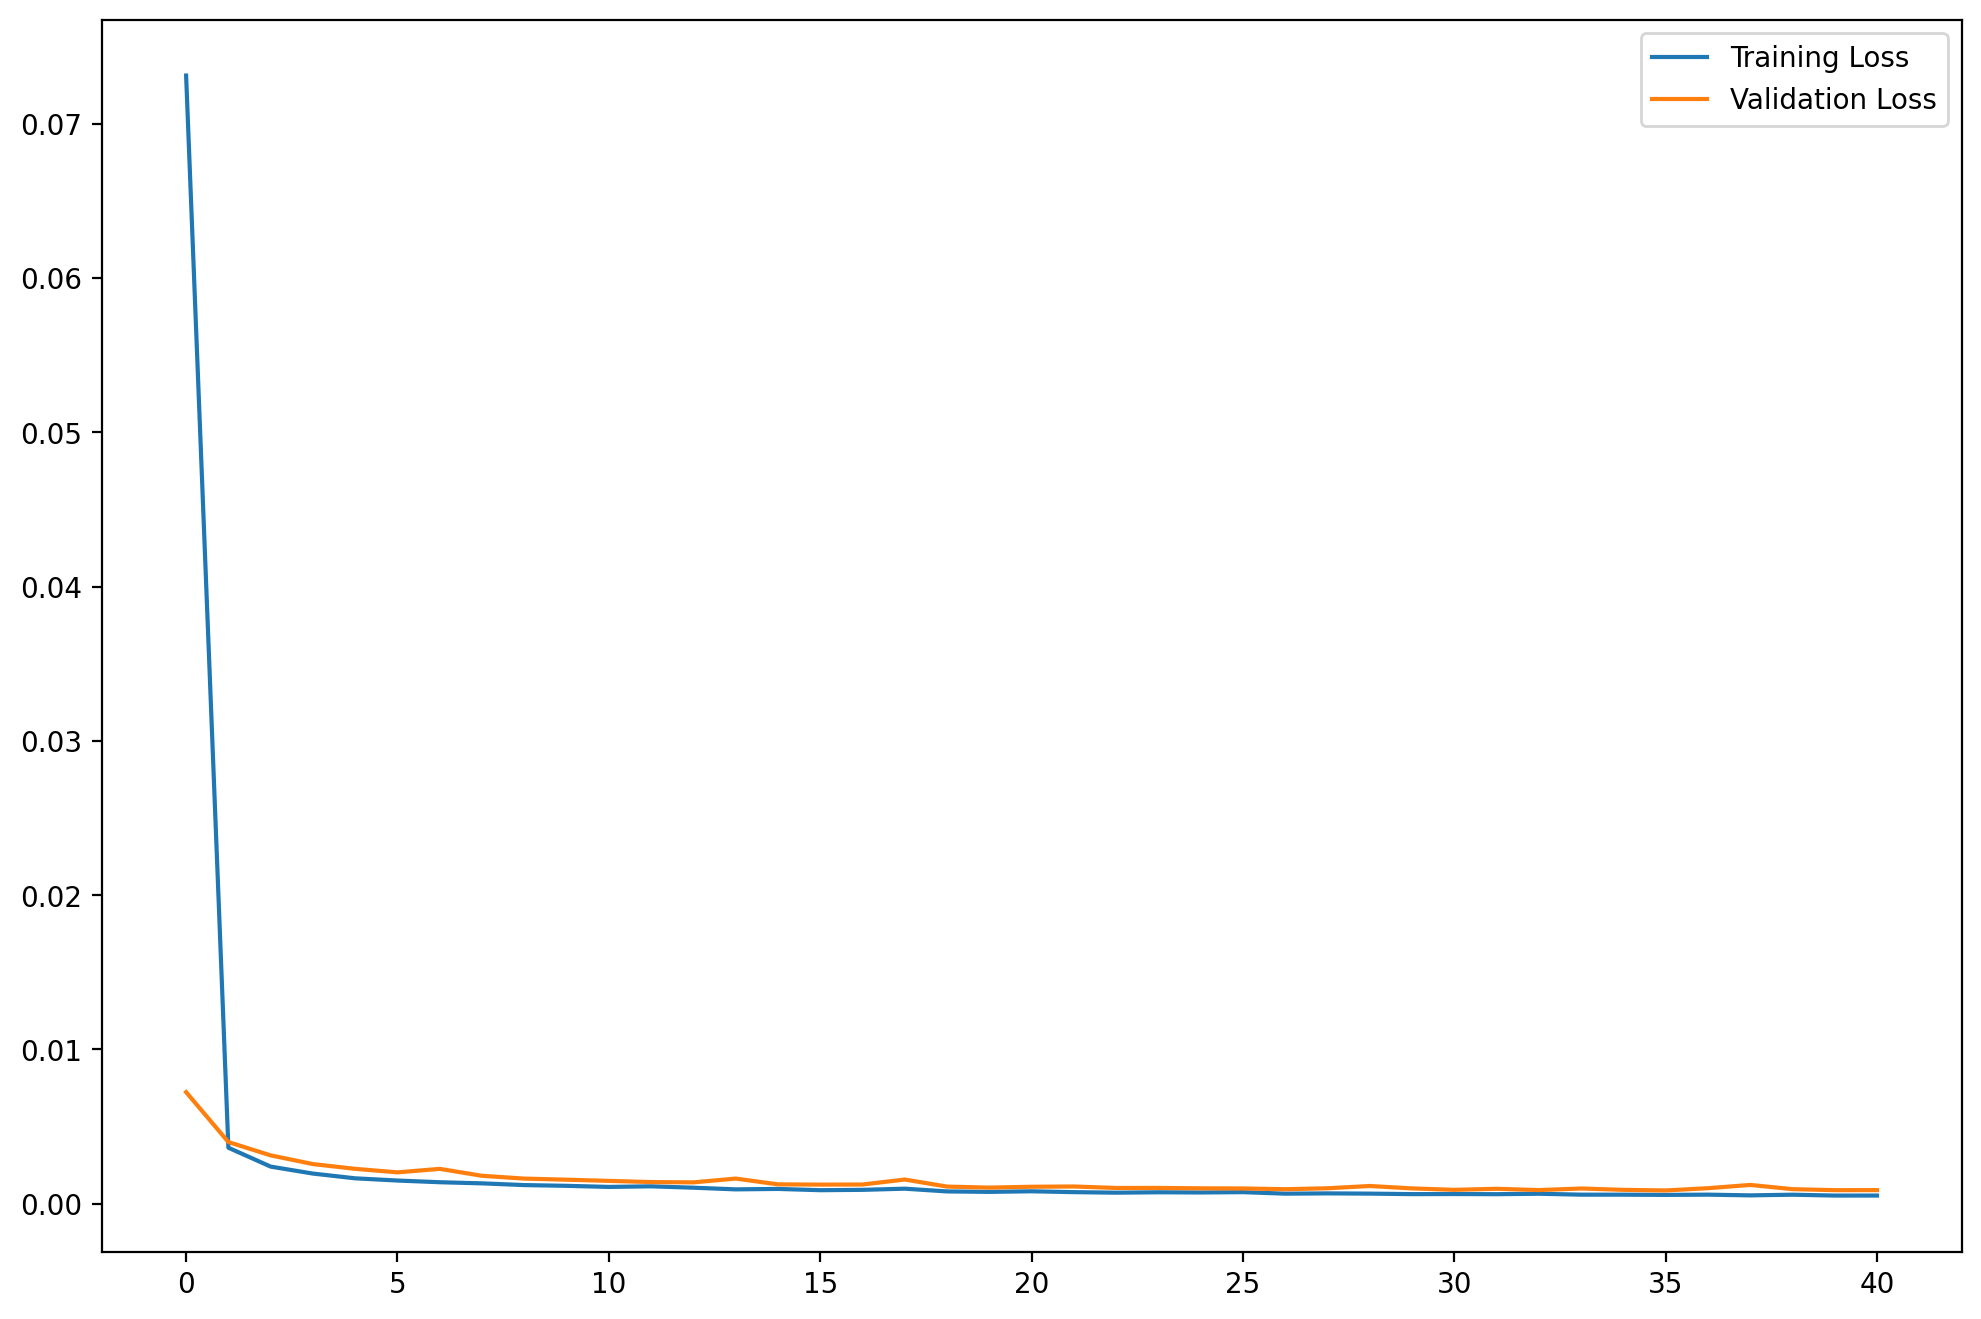

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

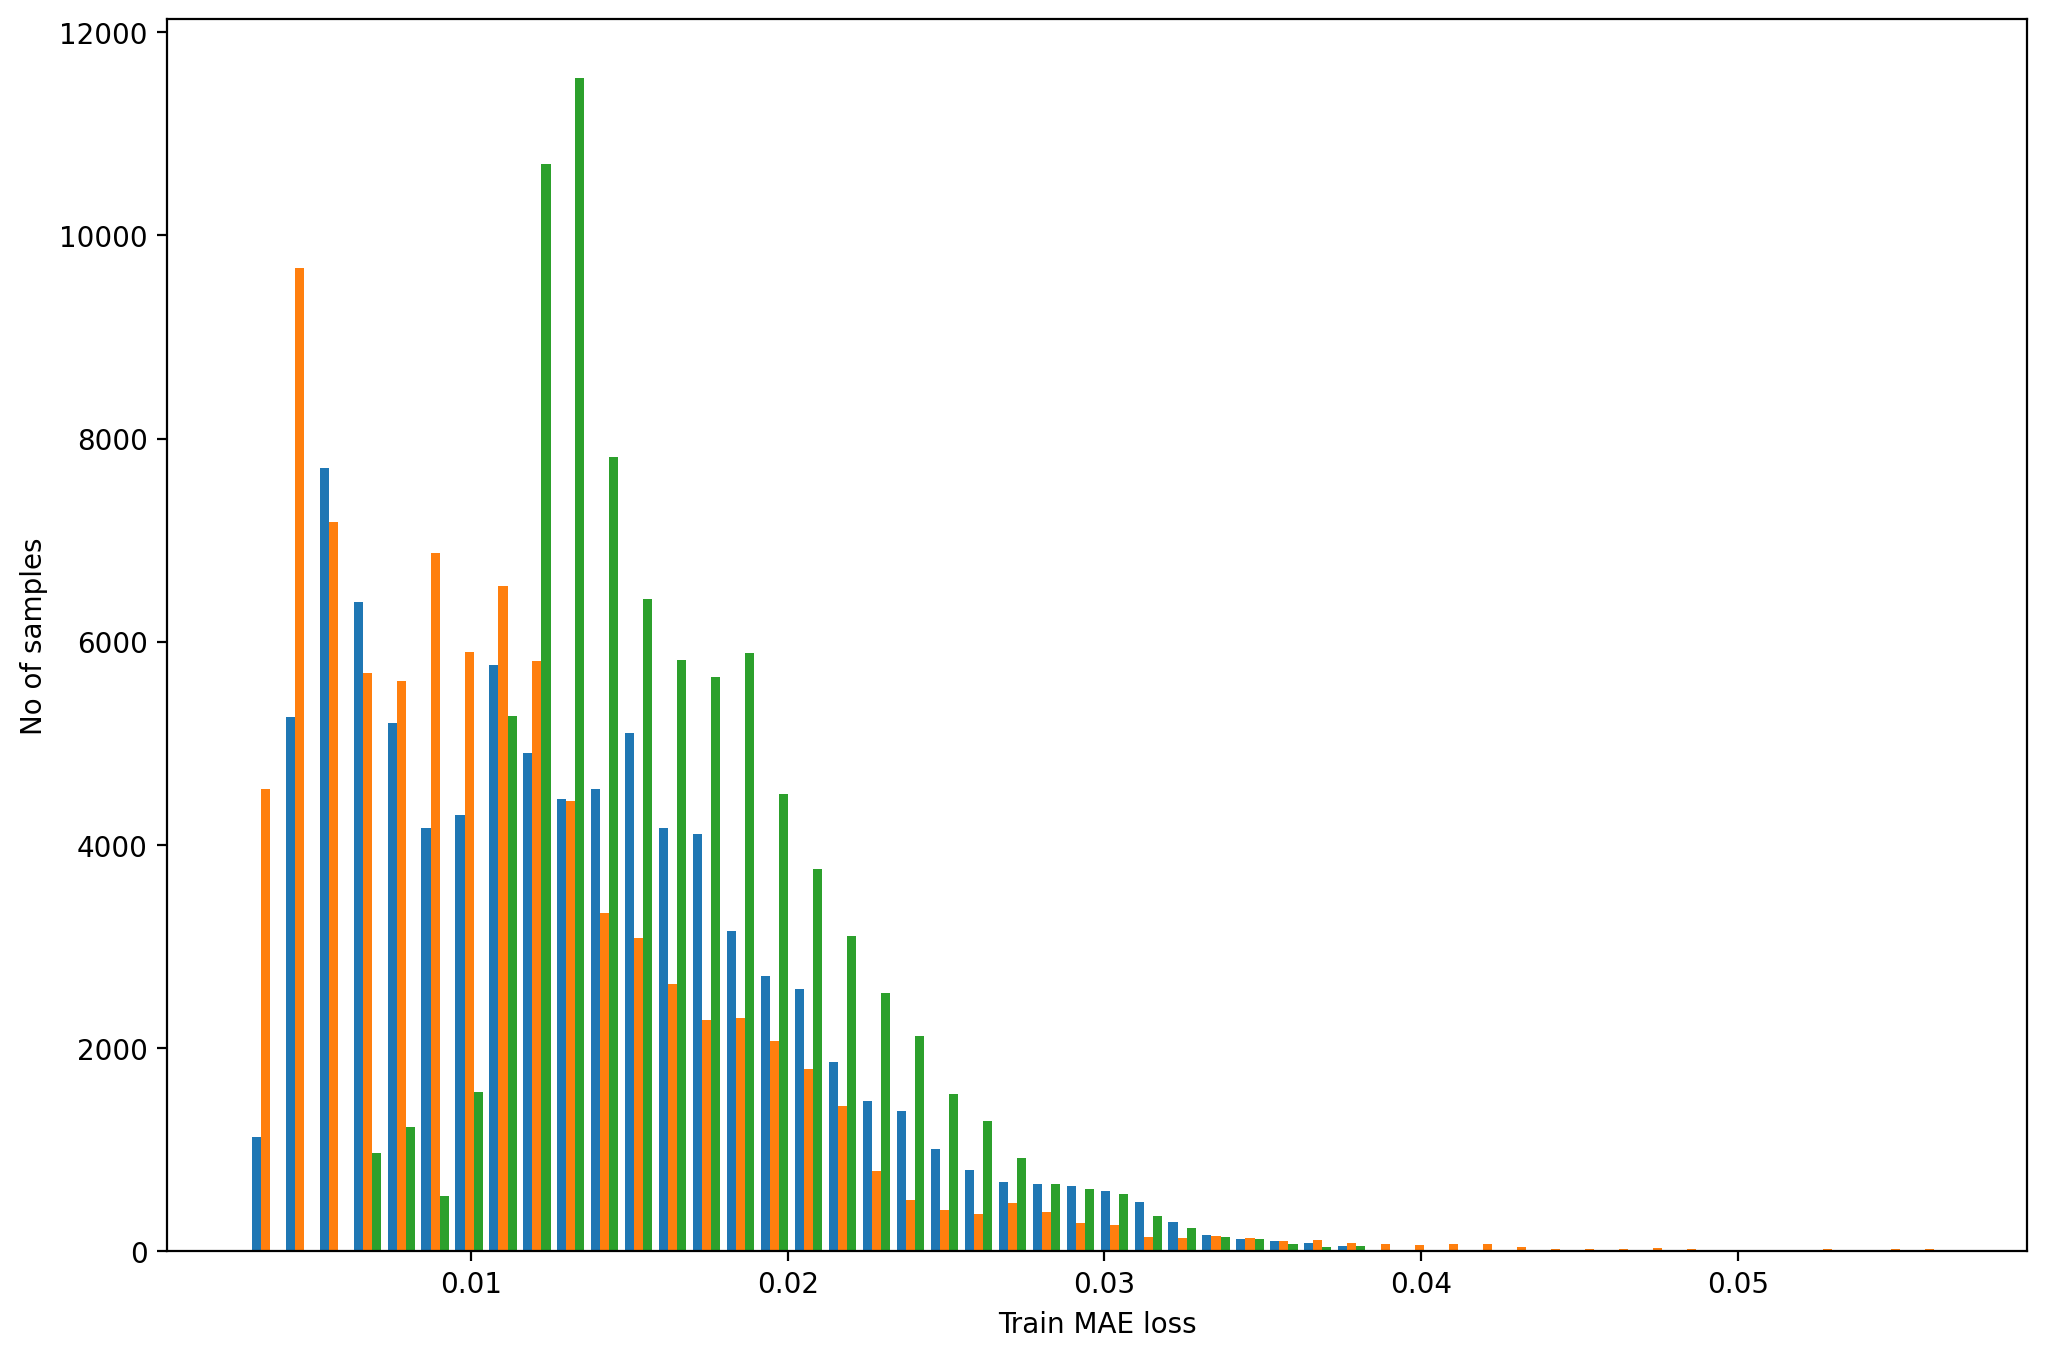

Reconstruction error threshold:  0.056571323


In [17]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

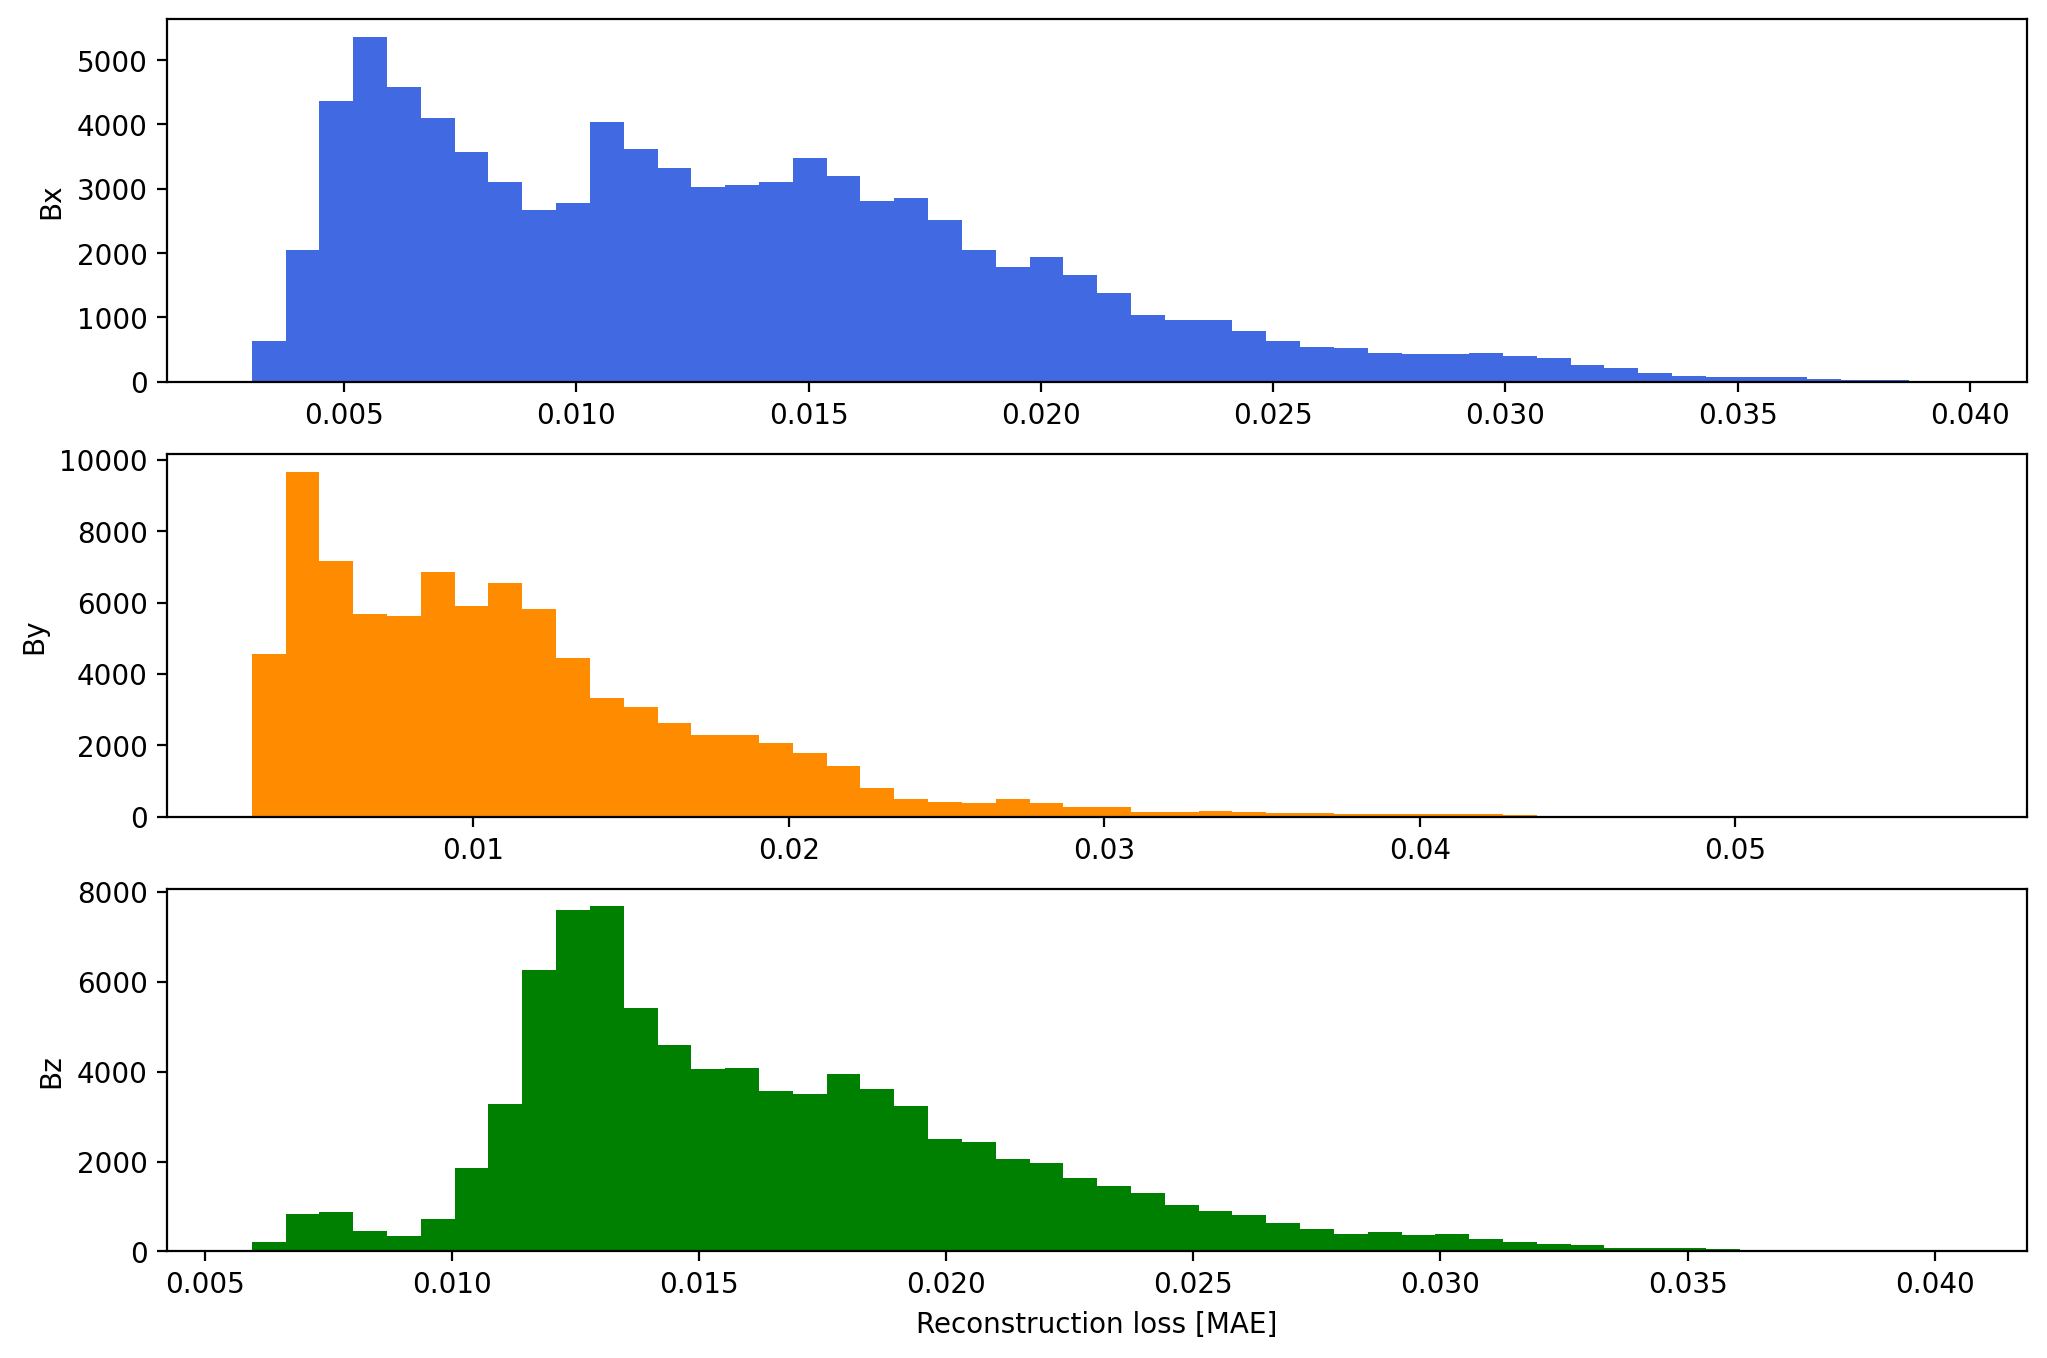

Reconstruction error threshold:  0.056571323


<Figure size 2400x1600 with 0 Axes>

In [18]:
# Get train MAE loss.
fig, axs = plt.subplots(3, 1)

x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

axs[0].hist(train_mae_loss[:,0], color='royalblue', bins=50, label='Bx')
axs[1].hist(train_mae_loss[:,1], color='darkorange', bins=50, label='By')
axs[2].hist(train_mae_loss[:,2], color='green', bins=50, label='Bz')

axs[0].set(ylabel='Bx')
axs[1].set(ylabel='By')
axs[2].set(ylabel='Bz')

axs[2].set(xlabel='Reconstruction loss [MAE]')

plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.tight_layout()

In [19]:
threshold = 0.05

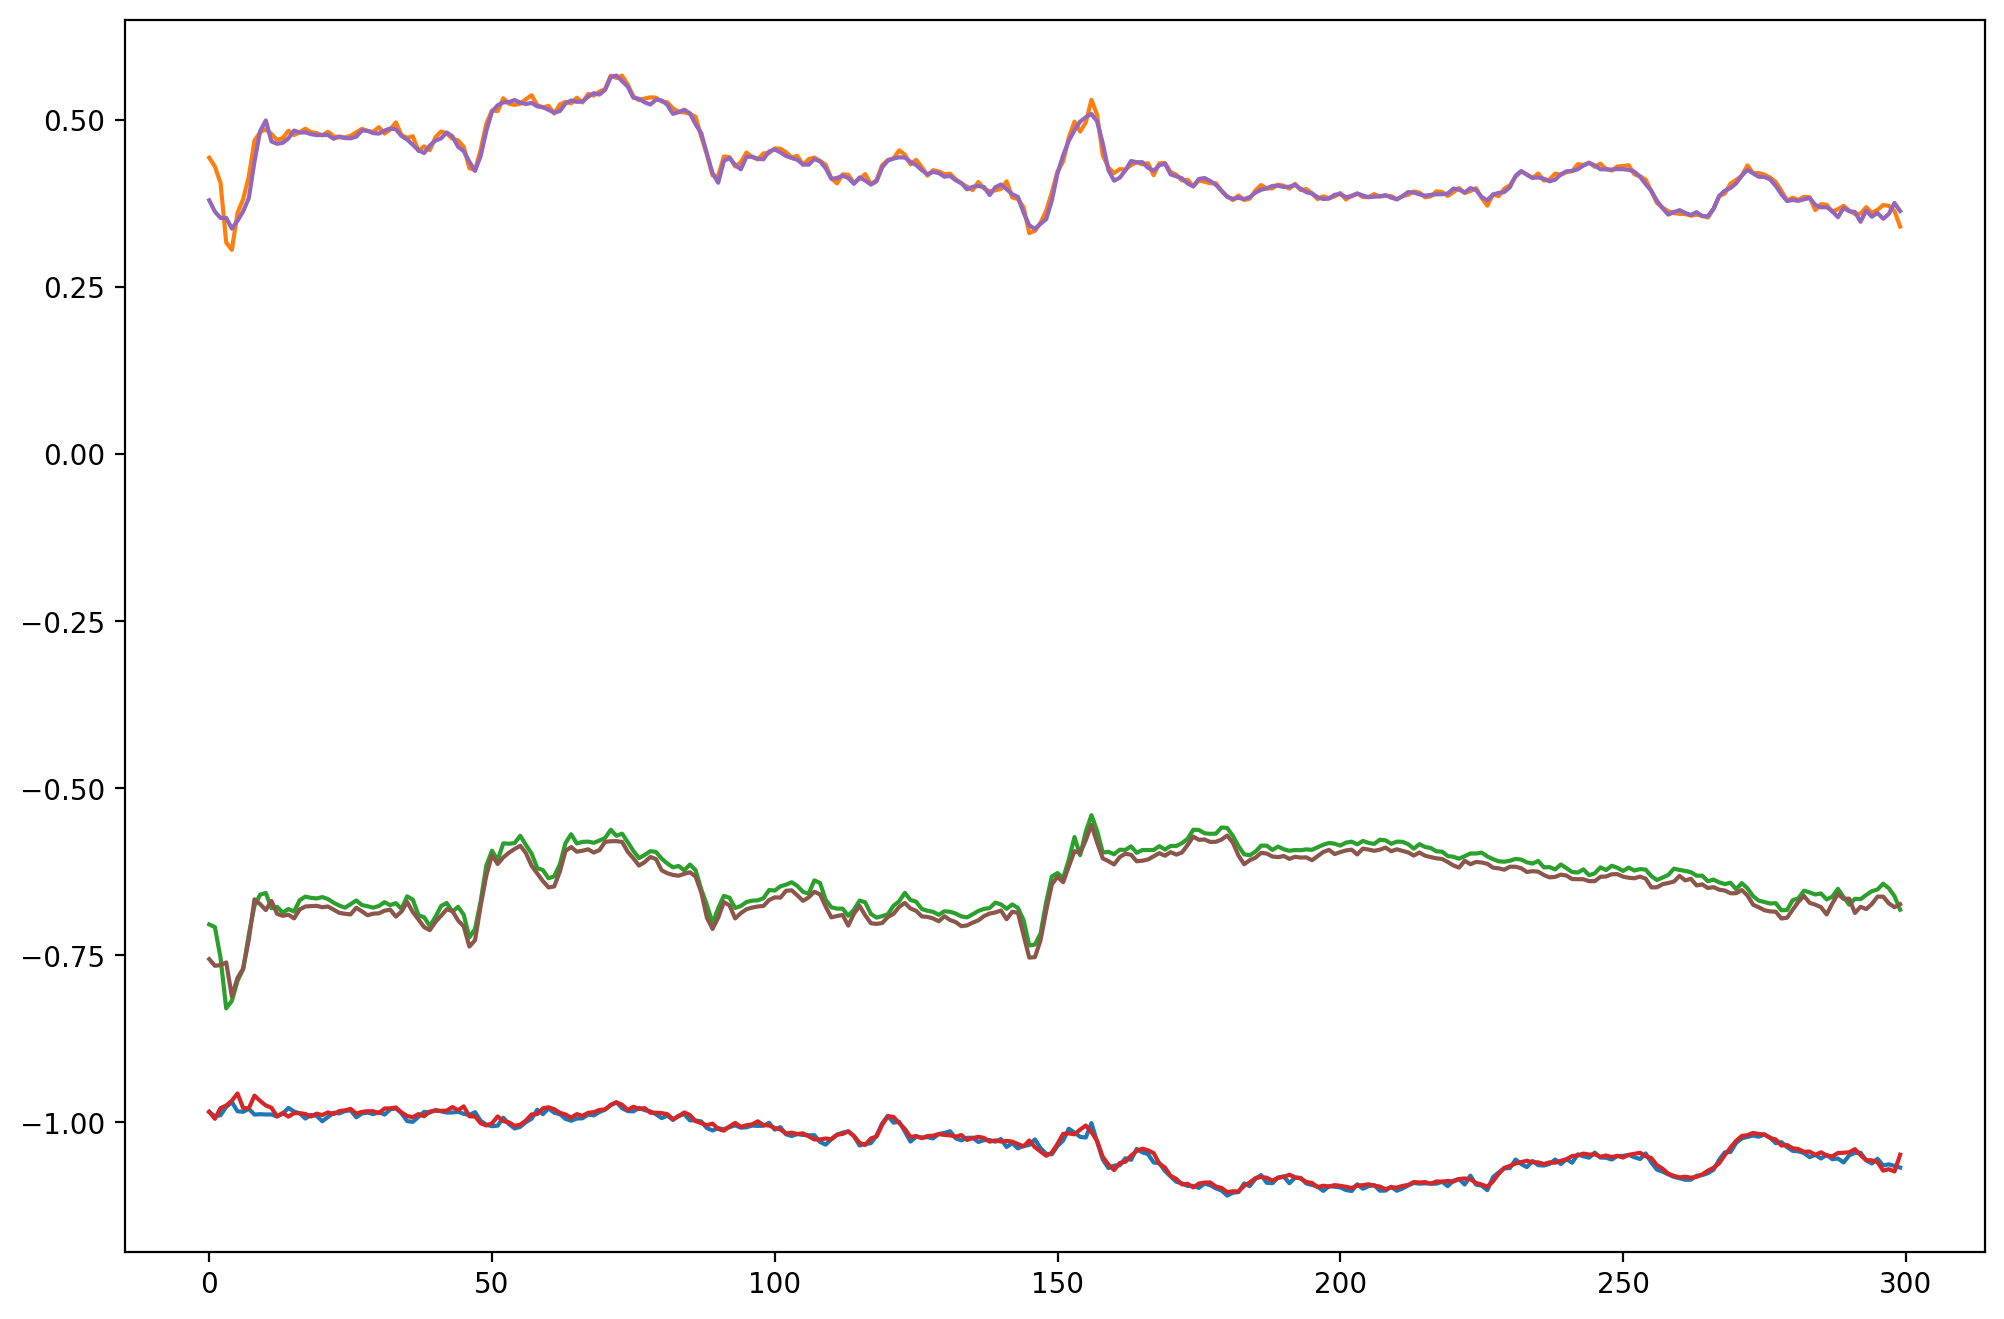

In [20]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

(86400, 3)
Test input shape:  (86101, 300, 3)
Test output shape:  (86101, 300, 3)
(86101, 3)


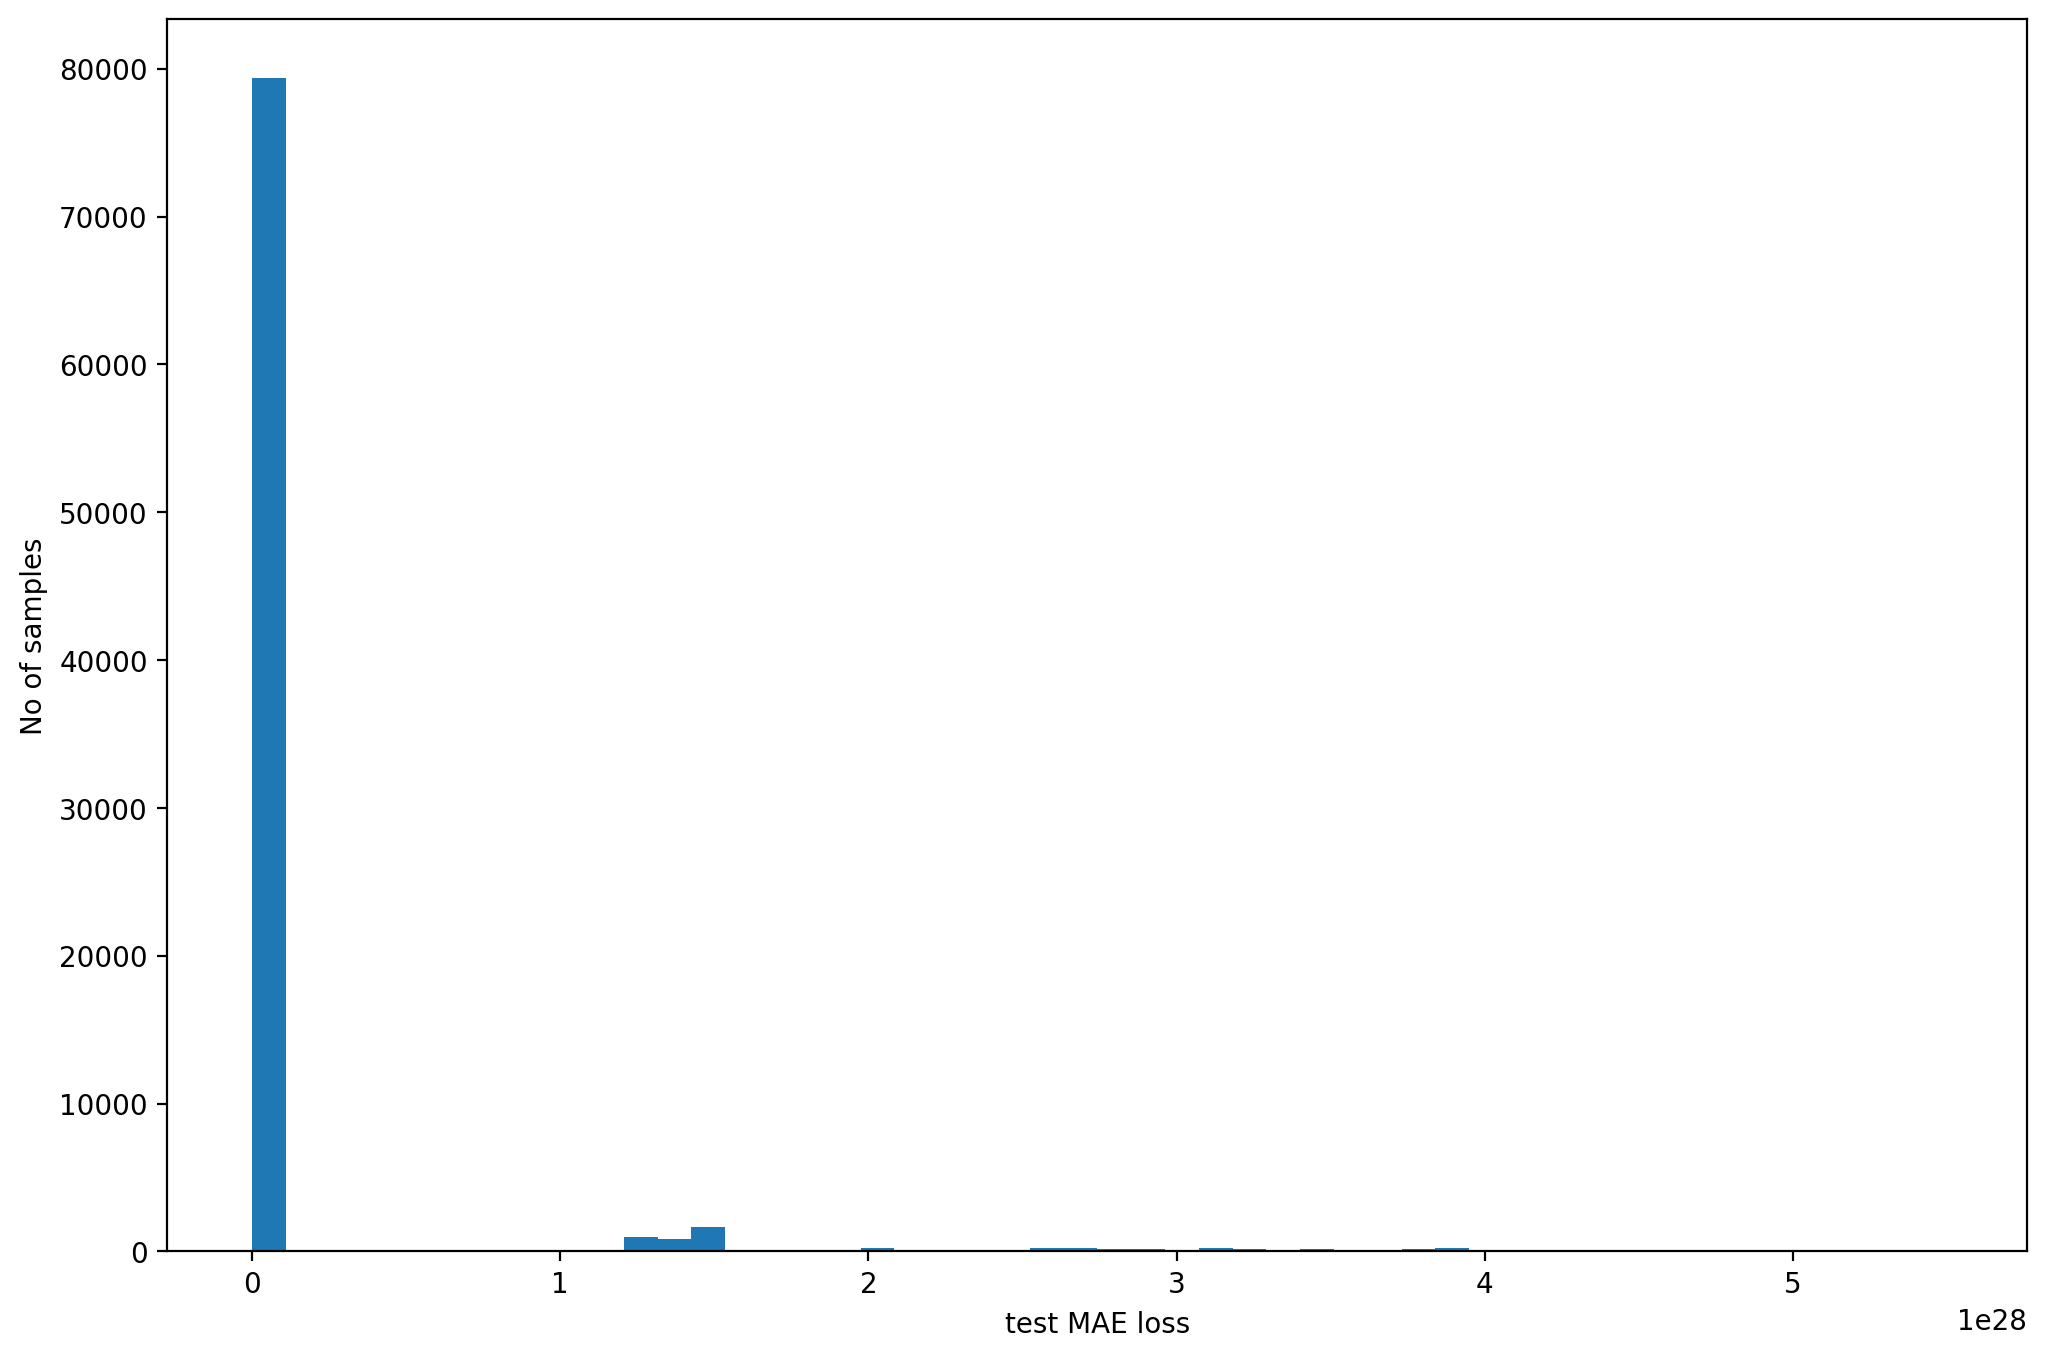

Number of anomaly samples:  6984
Indices of anomaly samples:  (array([ 1945,  1946,  1947, ..., 83497, 83498, 83499]),)


In [21]:
print(d_b.shape)
df_test_value = (d_b  - training_mean) / training_std

x_test = create_sequences(df_test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
print("Test output shape: ", x_test_pred.shape)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

#test_mae_loss = test_mae_loss.reshape((-1))
print(test_mae_loss.shape)

plt.hist(test_mae_loss[:,0], bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss[:,0] > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

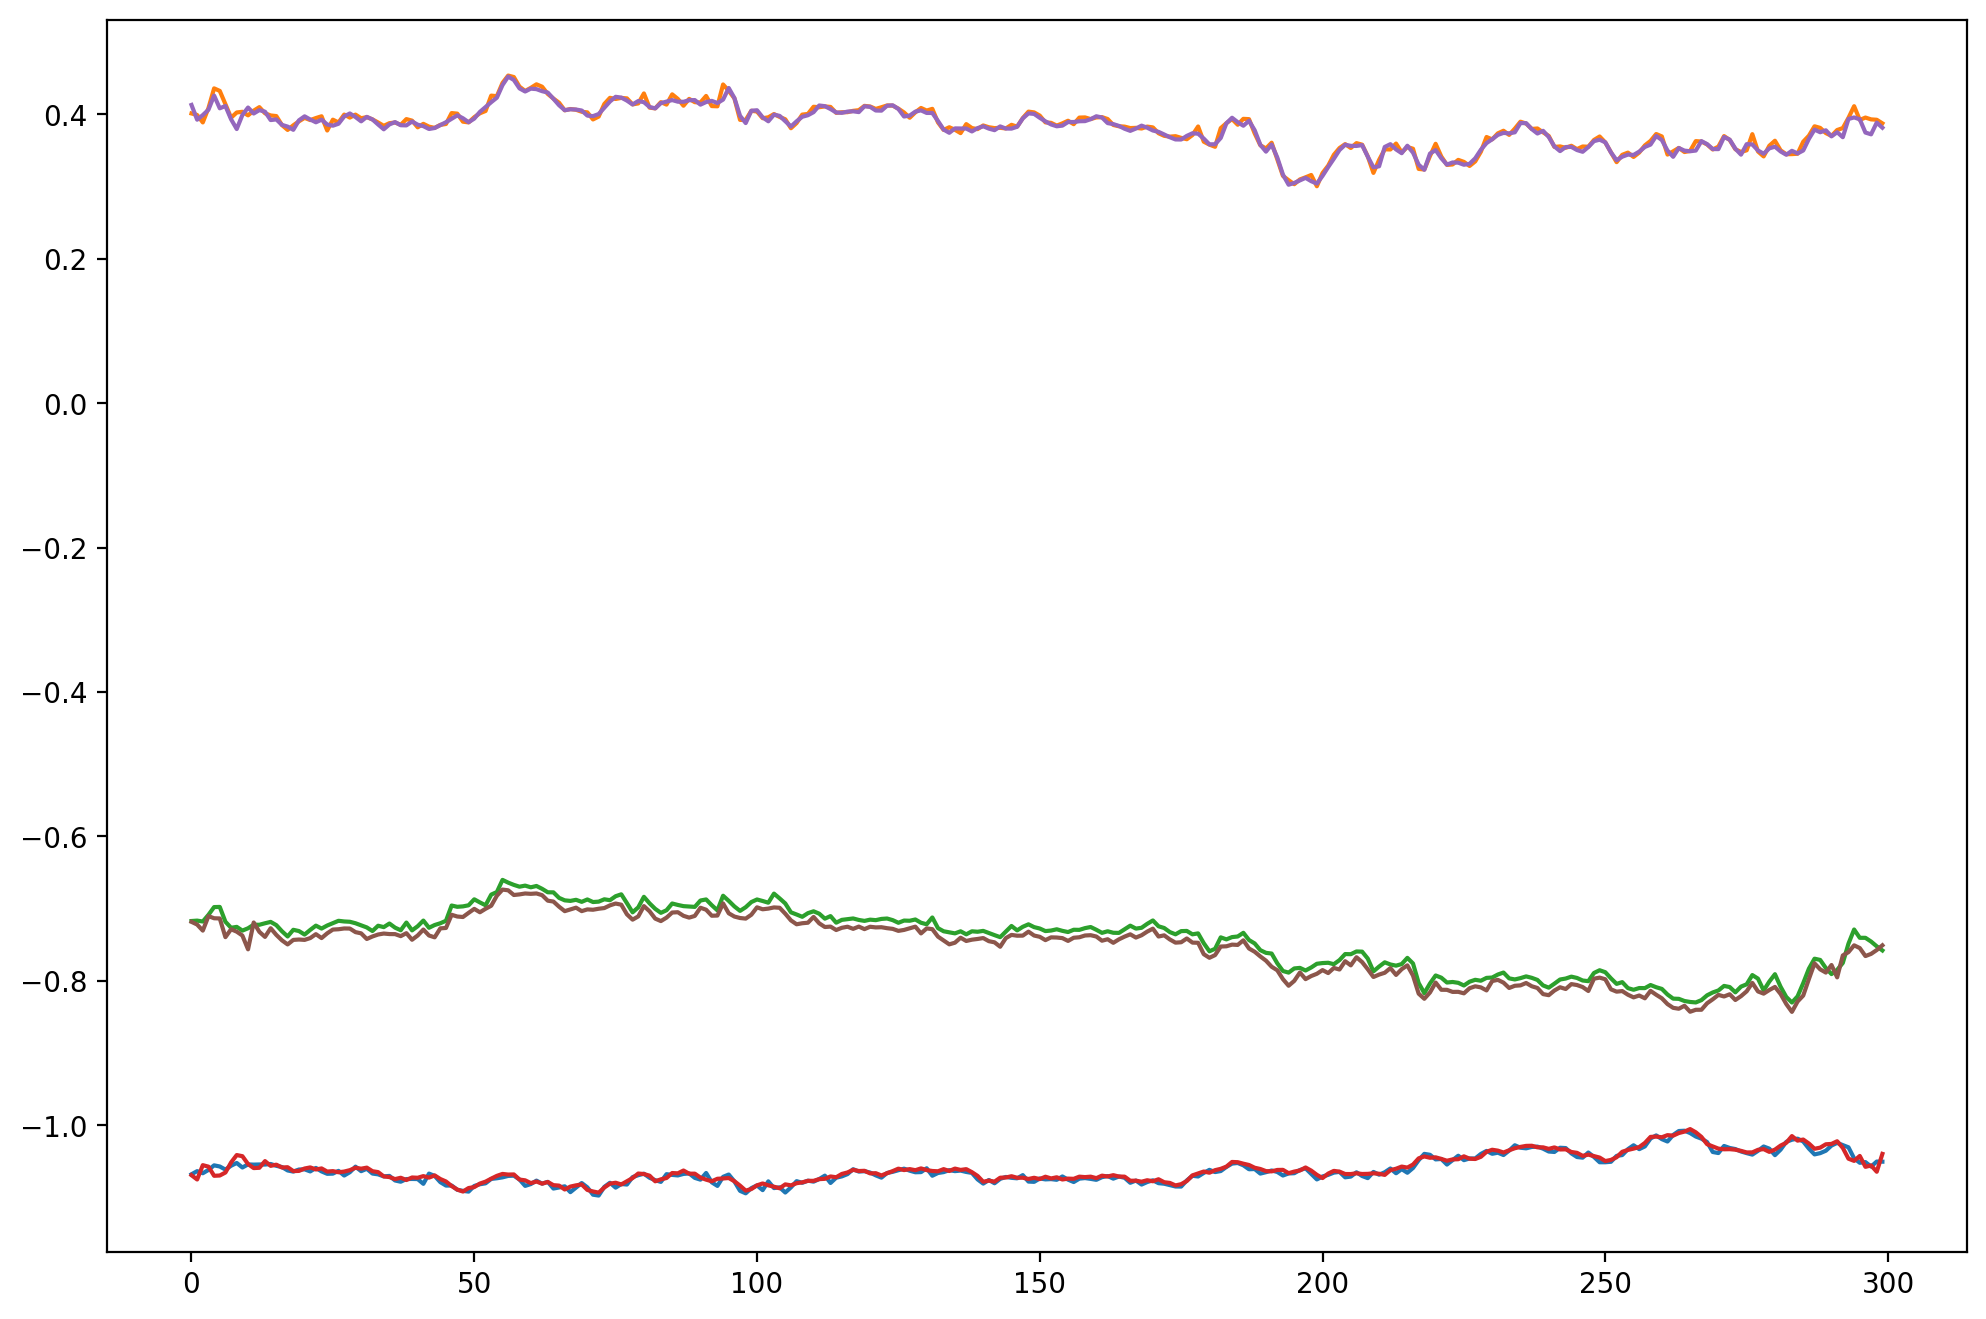

In [22]:
# Checking how the first sequence is learnt
plt.plot(x_test[0])
plt.plot(x_test_pred[0])
plt.show()

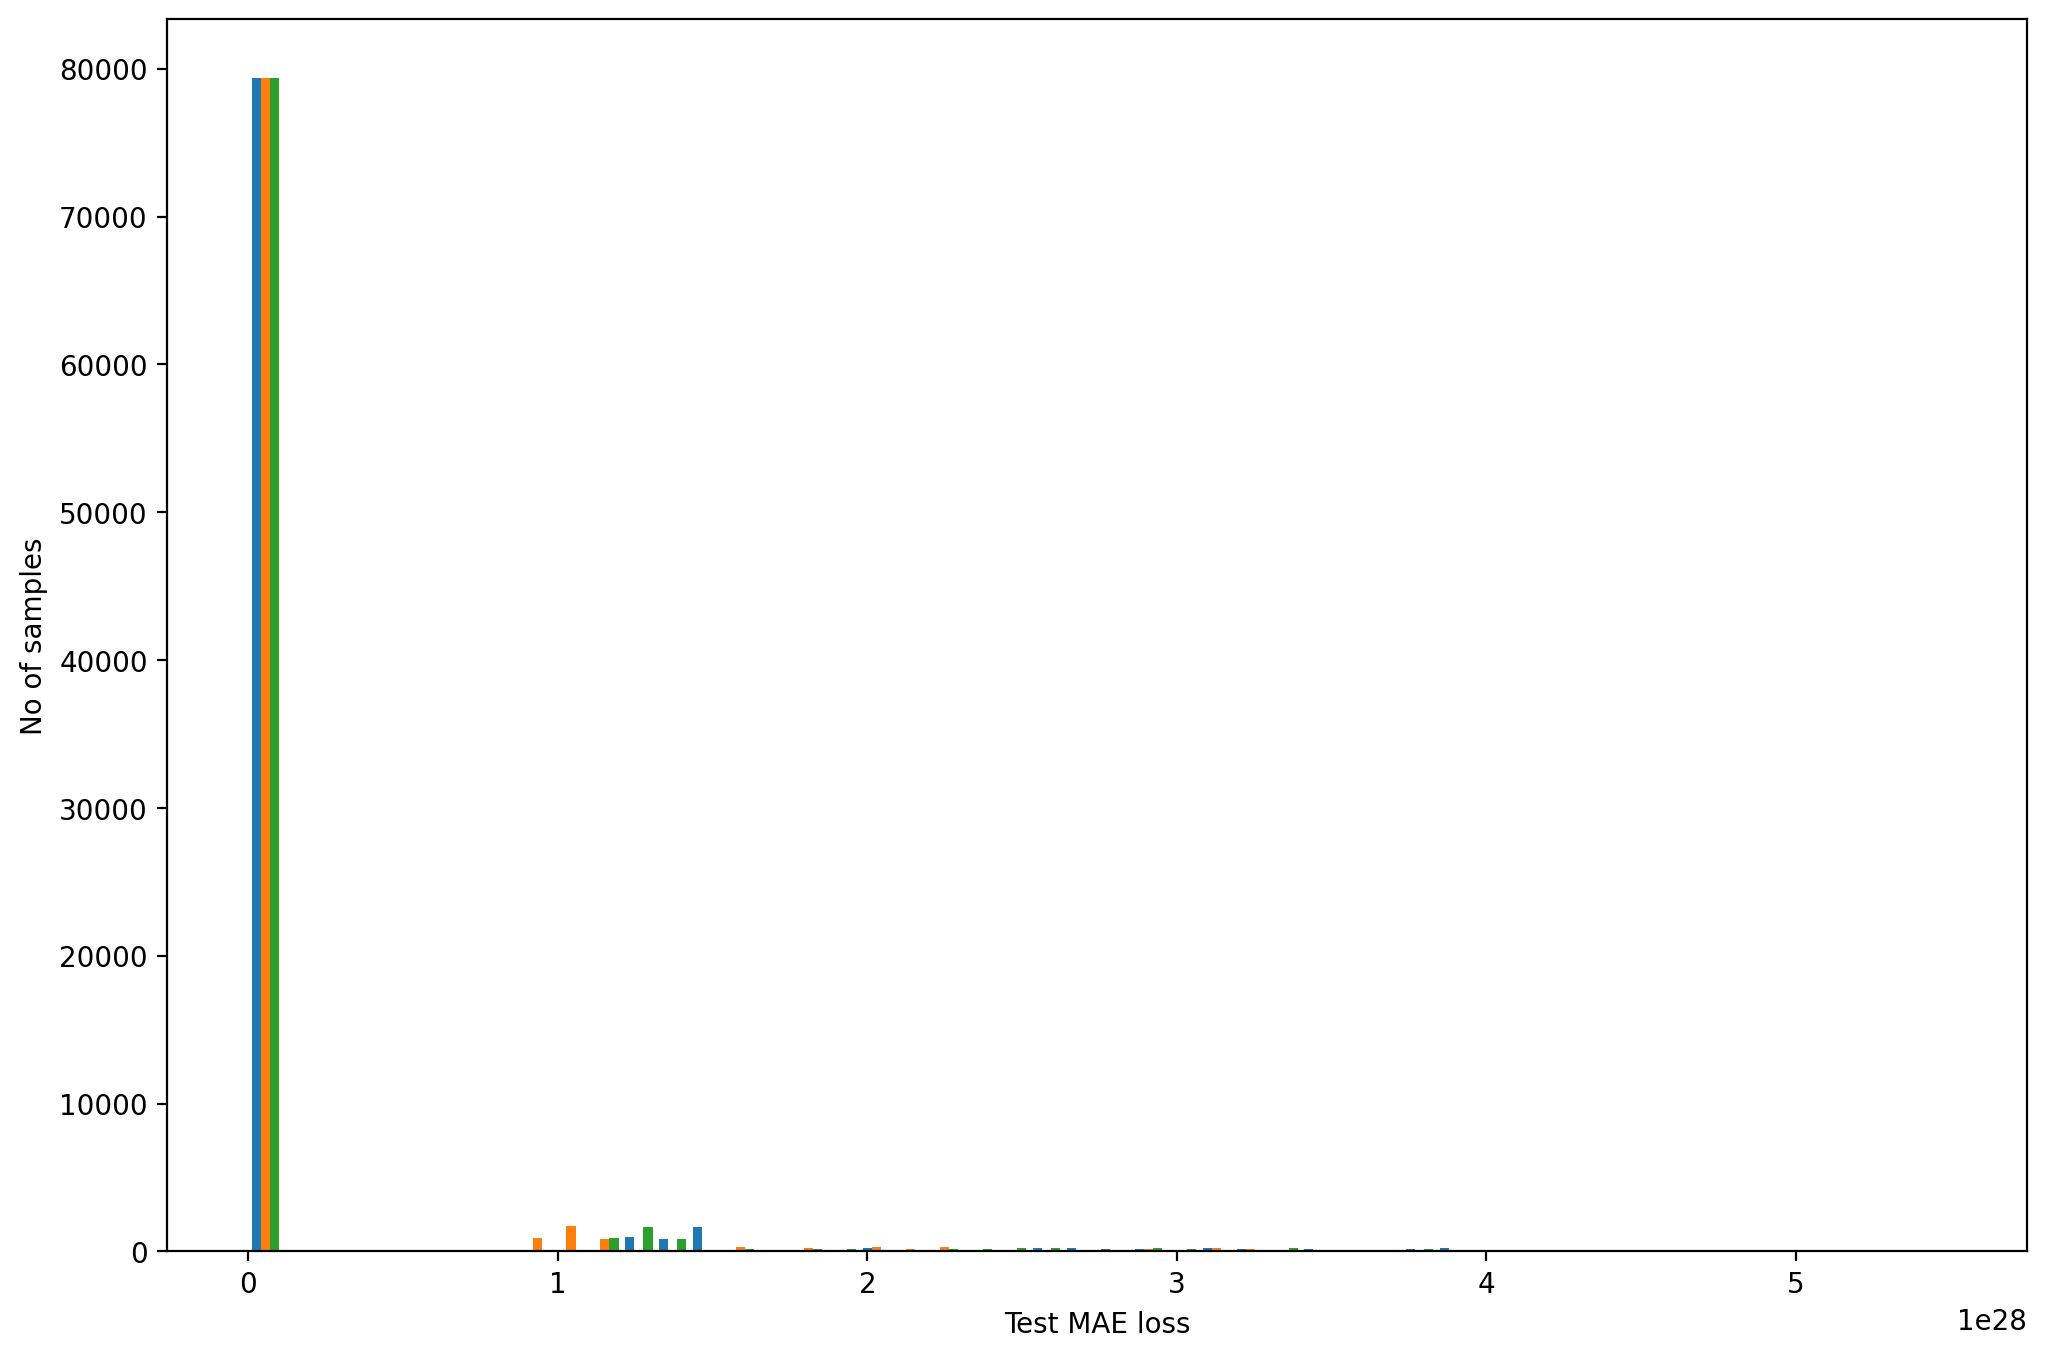

Reconstruction error threshold:  5.4858485e+28


In [23]:
# Get train MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(test_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [24]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
#for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
for data_idx in range(TIME_STEPS - 1, len(df_test_value)):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [25]:
anomalous_data_indices = np.where(anomalies)[0]
print(len(anomalous_data_indices))

6984


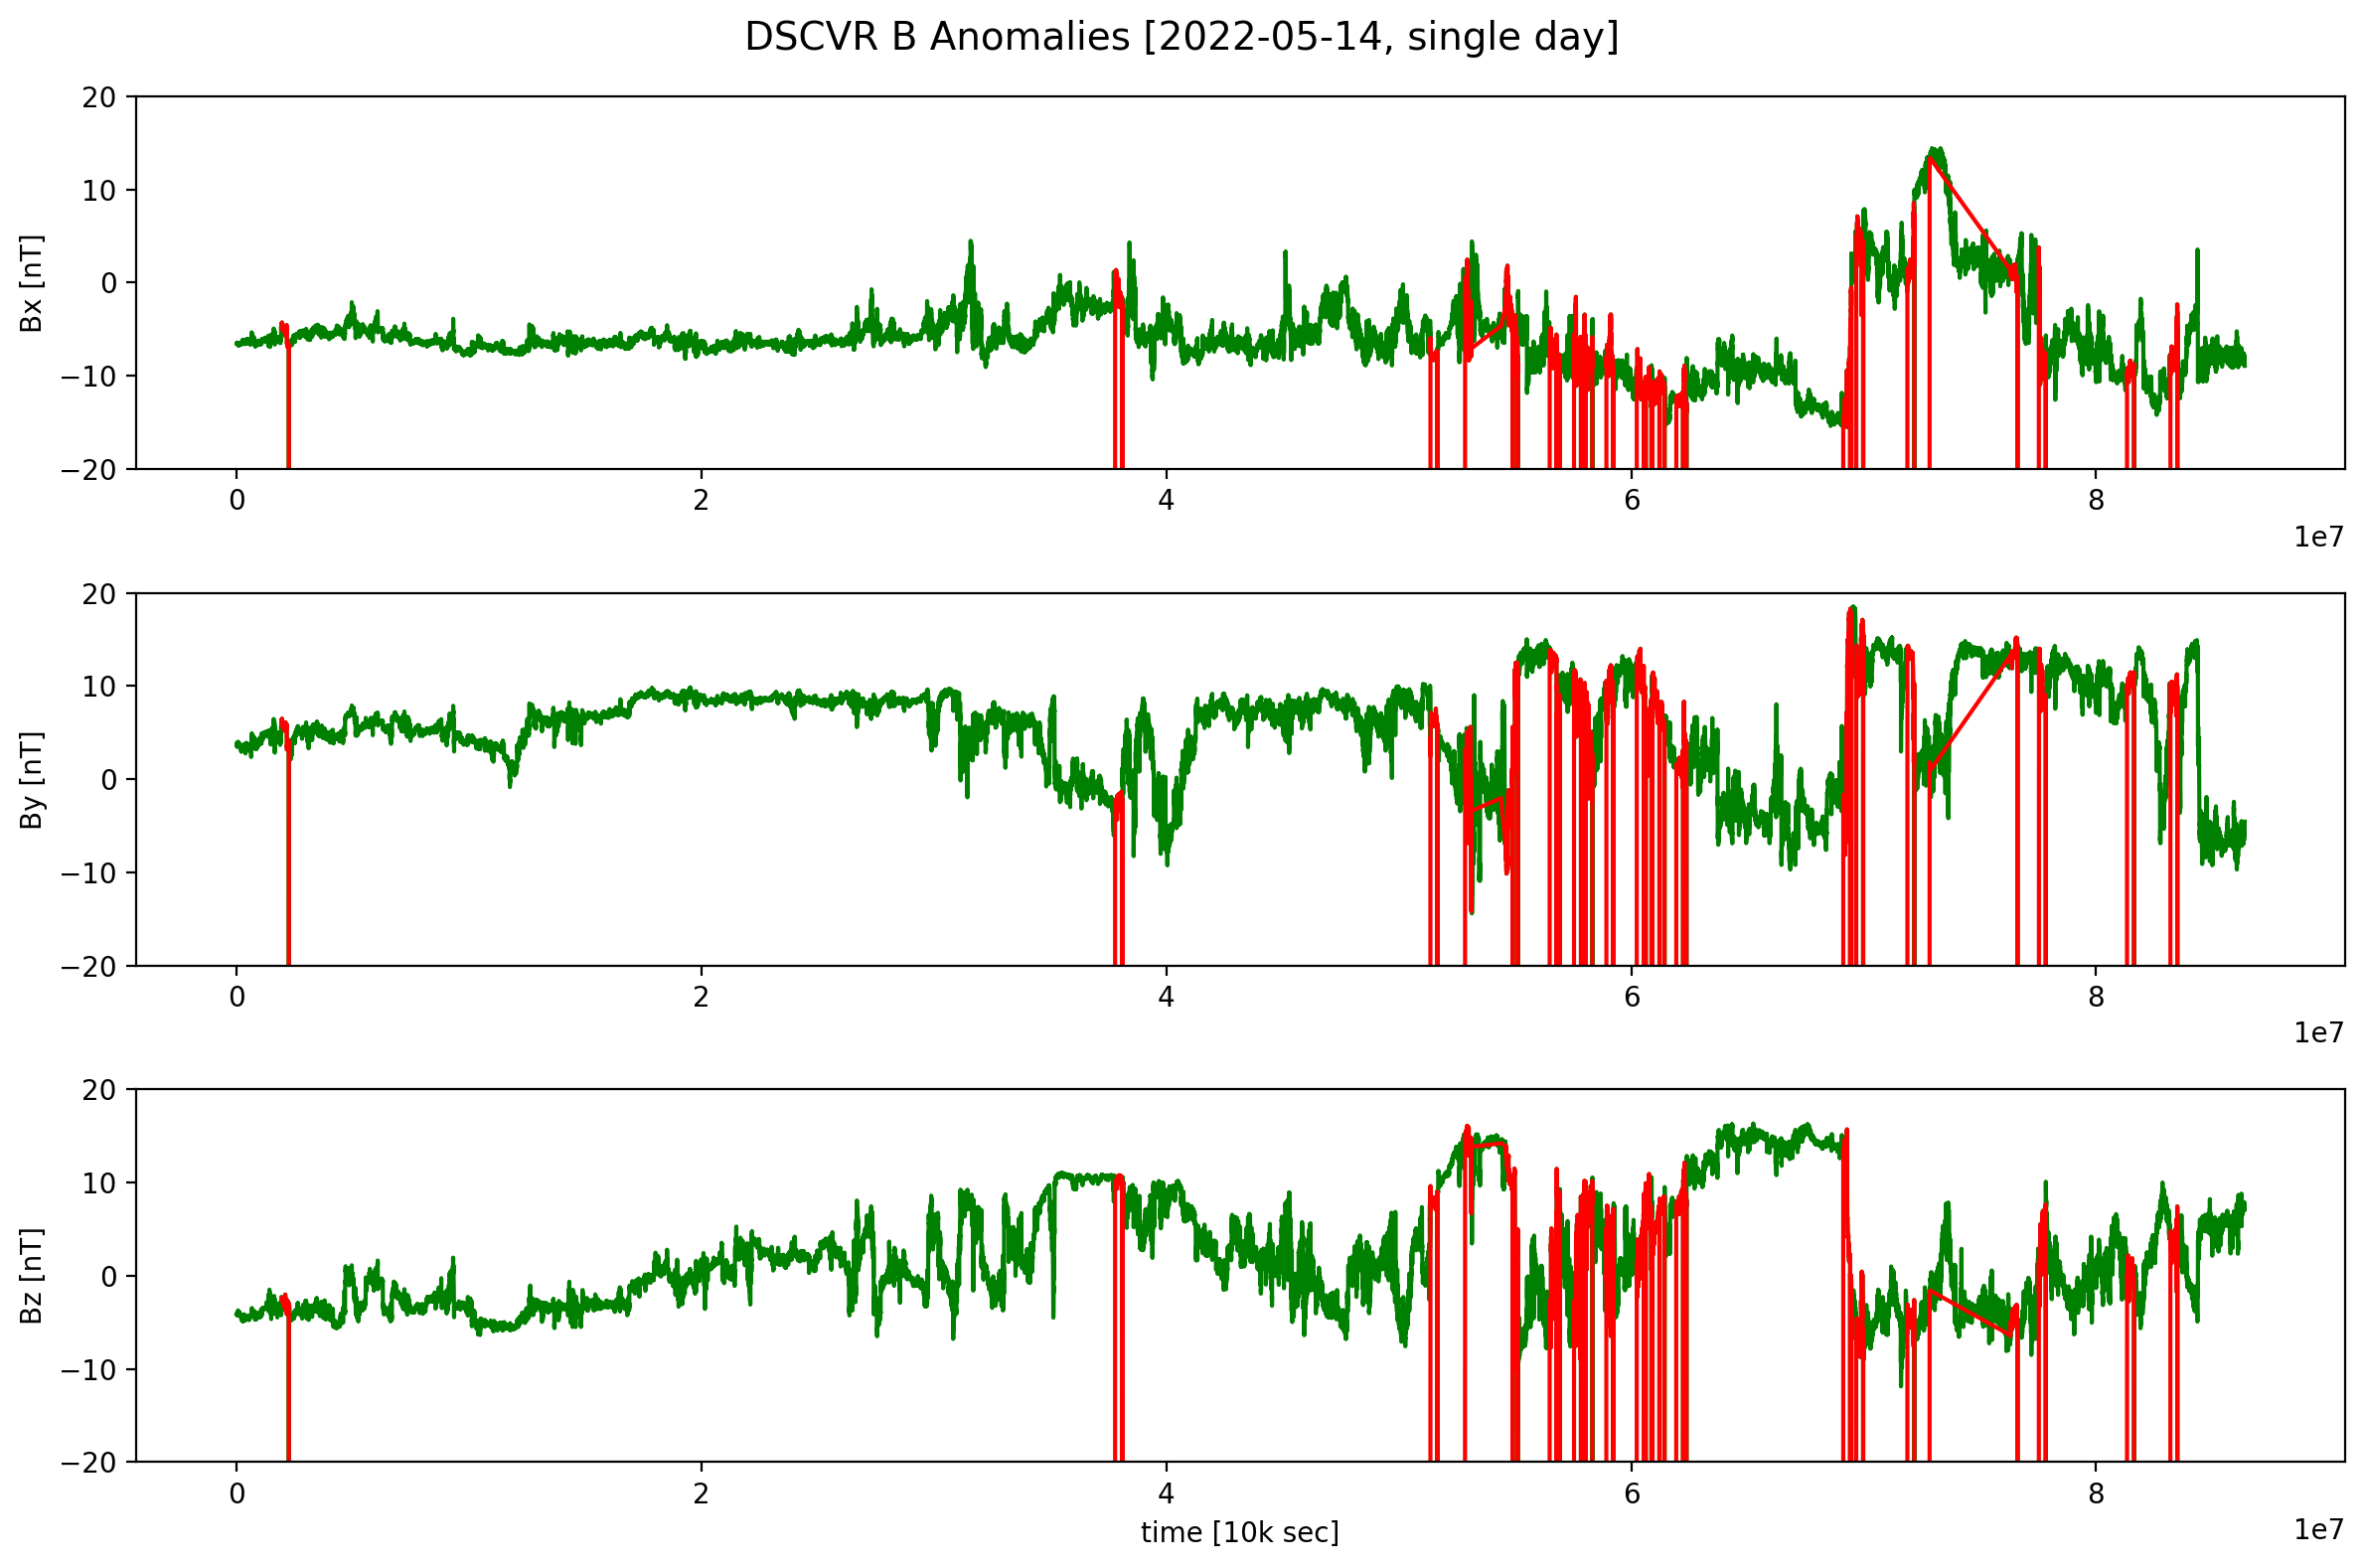

In [26]:
fig, axs = plt.subplots(3, 1)
title = 'DSCVR B Anomalies [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

d_t = np.asarray(dsc_t[:,:])
d_b = np.asarray(dsc_B[:,:])
a_t = d_t[anomalous_data_indices]
a_b = d_b[anomalous_data_indices]

d_bx, = axs[0].plot(dsc_t[:,2], dsc_B[:,0], color=dsc_colour, label='Bx')
d_by, = axs[1].plot(dsc_t[:,2], dsc_B[:,1], color=dsc_colour, label='By')
d_bz, = axs[2].plot(dsc_t[:,2], dsc_B[:,2], color=dsc_colour, label='Bz')

a_bx, = axs[0].plot(a_t[:,2], a_b[:,0], color=anl_colour)
a_by, = axs[1].plot(a_t[:,2], a_b[:,1], color=anl_colour)
a_bz, = axs[2].plot(a_t[:,2], a_b[:,2], color=anl_colour)

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

axs[0].set(ylim=(-20,20))
axs[1].set(ylim=(-20,20))
axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

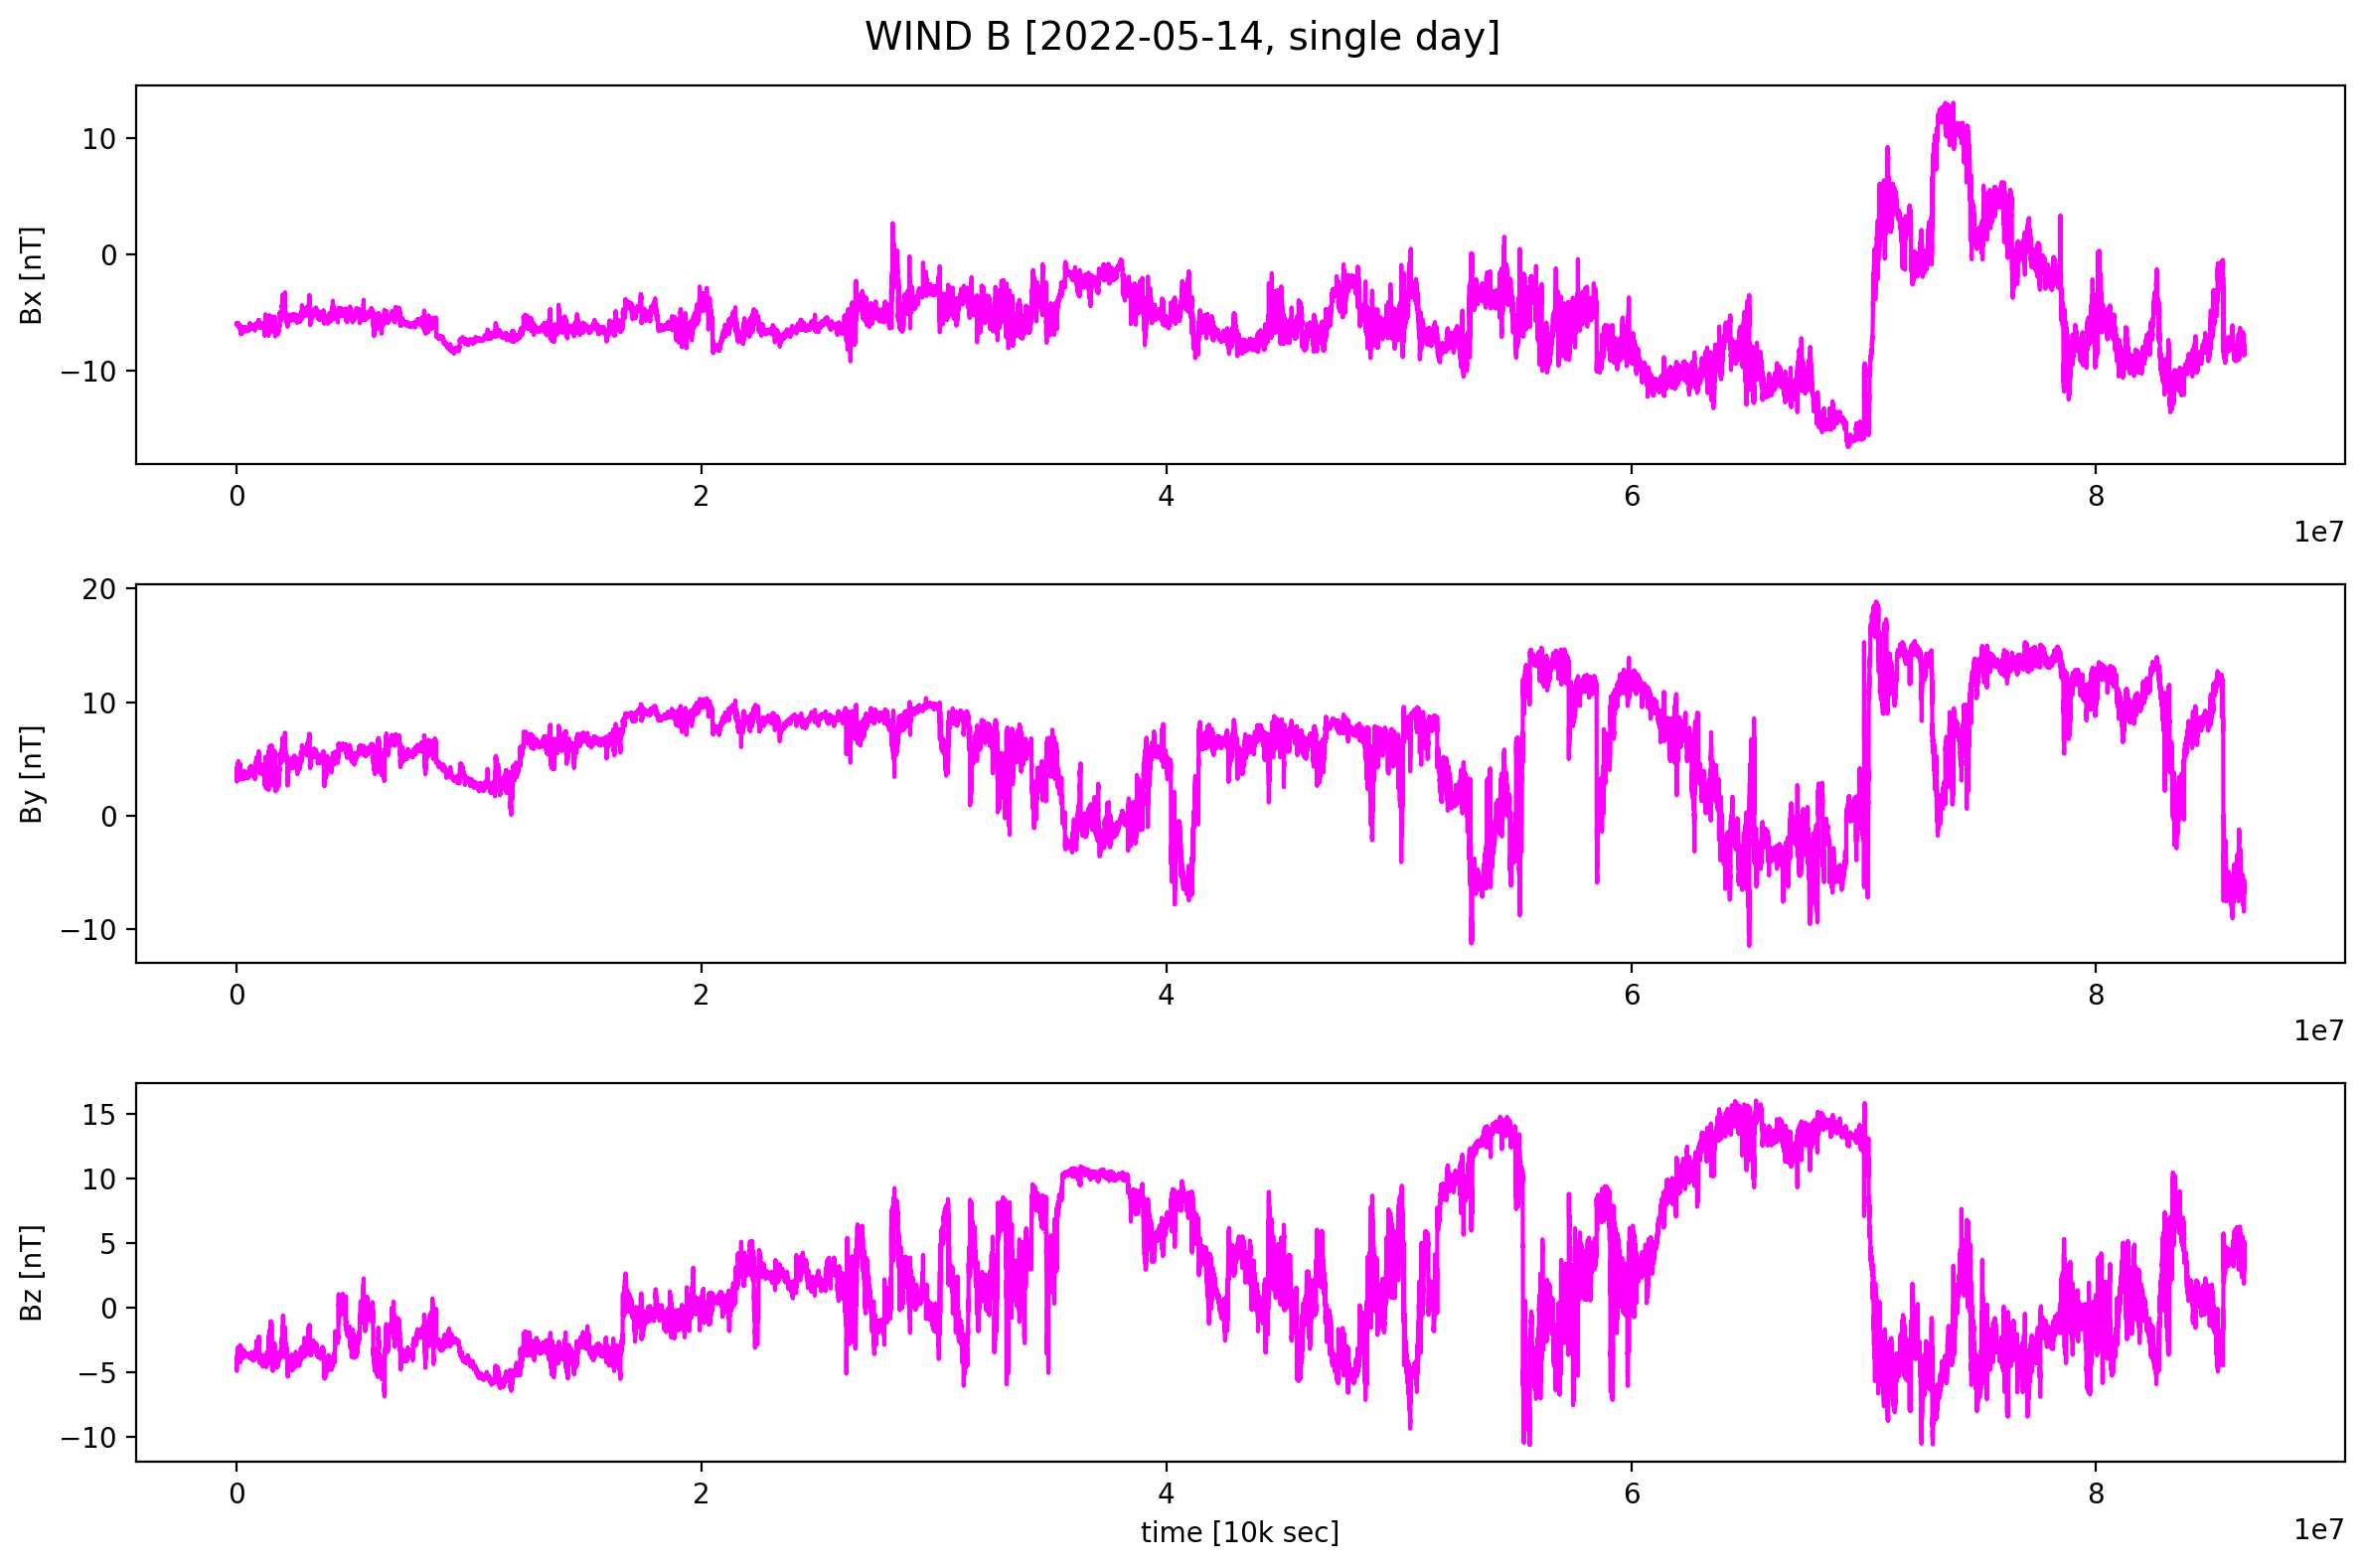

In [27]:
fig, axs = plt.subplots(3, 1)
title = 'WIND B [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

w_t = np.asarray(wnd_t[:,:])
w_b = np.asarray(wnd_B[:,:])

w_bx, = axs[0].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')
w_by, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')
w_bz, = axs[2].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

#axs[0].set(ylim=(-20,20))
#axs[1].set(ylim=(-20,20))
#axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

In [28]:
good_data_indices = np.where(np.logical_not(anomalies))[0]
print(len(good_data_indices))

79117


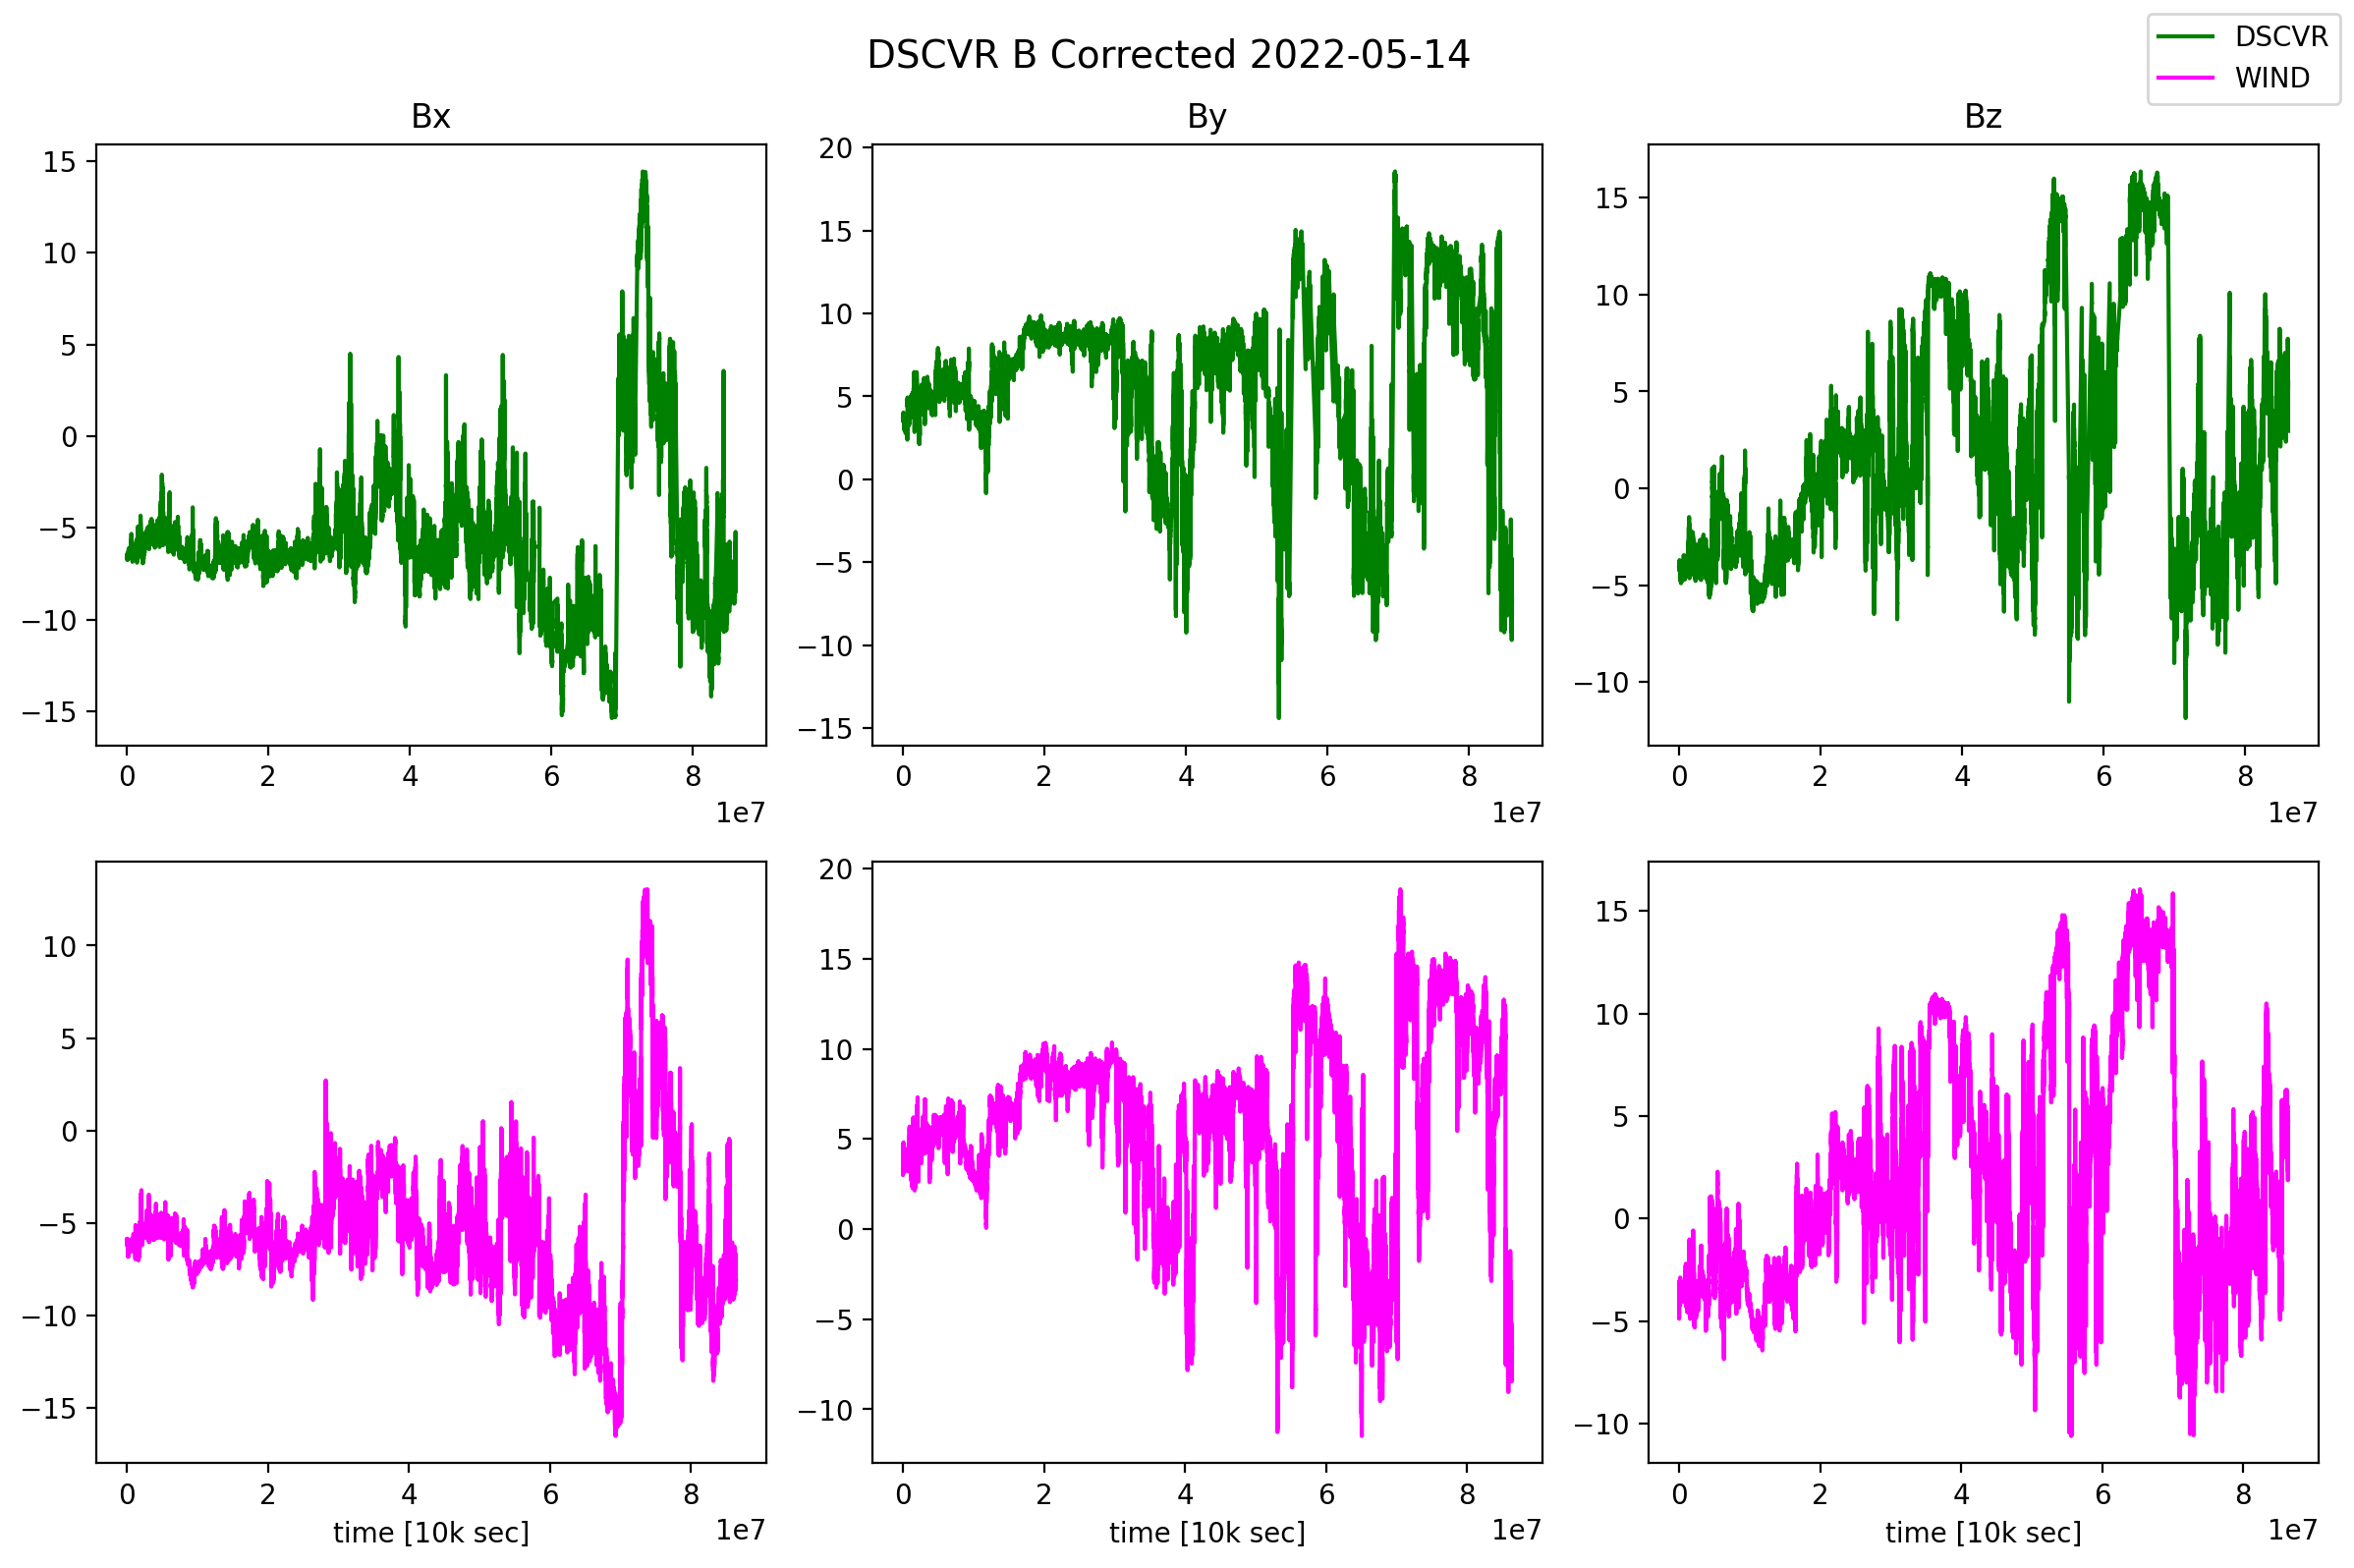

In [29]:
fig, axs = plt.subplots(2, 3)
title = 'DSCVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_t = np.asarray(dsc_t[:,:])
d_b = np.asarray(dsc_B[:,:])
g_t = d_t[good_data_indices]
g_b = d_b[good_data_indices]

d_bx, = axs[0,0].plot(g_t[:,2], g_b[:,0], color=dsc_colour, label='Bx')
d_by, = axs[0,1].plot(g_t[:,2], g_b[:,1], color=dsc_colour, label='By')
d_bz, = axs[0,2].plot(g_t[:,2], g_b[:,2], color=dsc_colour, label='Bz')

axs[0, 0].set(title='Bx')
axs[0, 1].set(title='By')
axs[0, 2].set(title='Bz')

axs[1, 0].set(xlabel='time [10k sec]')
axs[1, 1].set(xlabel='time [10k sec]')
axs[1, 2].set(xlabel='time [10k sec]')

w_t = np.asarray(wnd_t[:,:])
w_b = np.asarray(wnd_B[:,:])

w_bx, = axs[1,0].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')
w_by, = axs[1,1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')
w_bz, = axs[1,2].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

fig.legend([d_bx, w_bx], ['DSCVR', 'WIND'], loc='upper right')

plt.tight_layout()

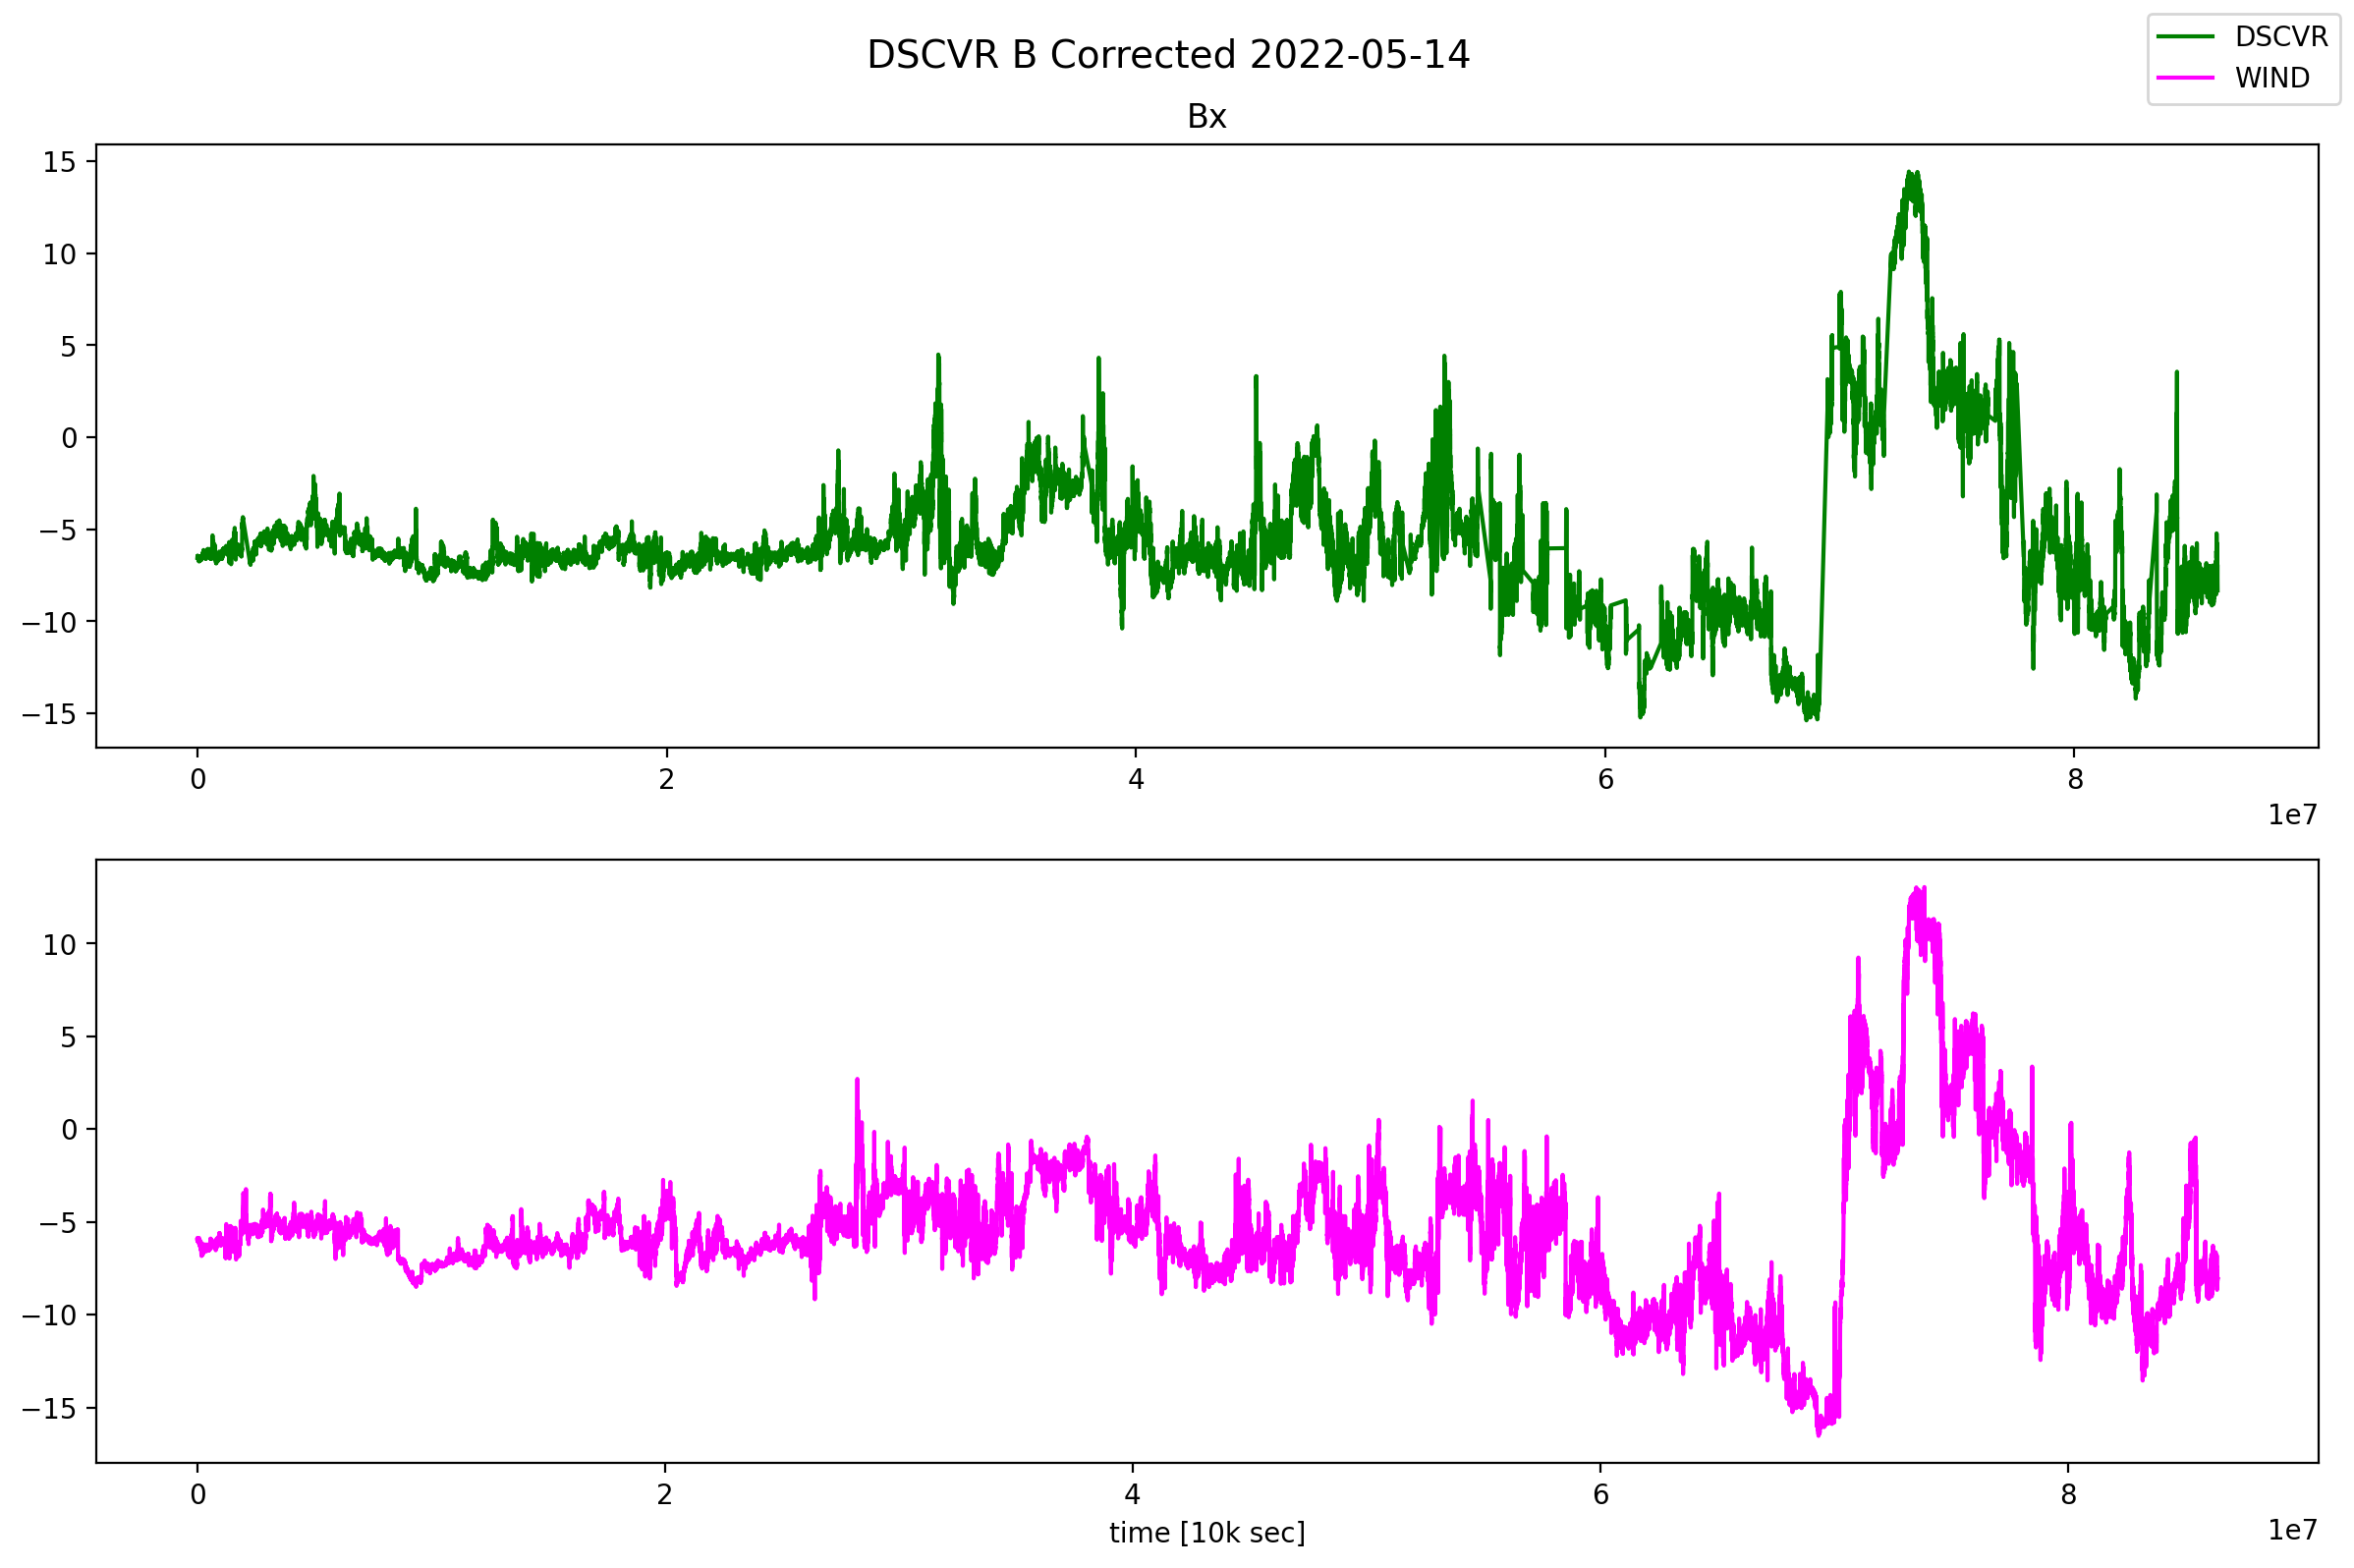

In [30]:
fig, axs = plt.subplots(2, 1)
title = 'DSCVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_bx, = axs[0].plot(g_t[:,2], g_b[:,0], color=dsc_colour, label='Bx')

axs[0].set(title='Bx')
axs[1].set(xlabel='time [10k sec]')

w_bx, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')

fig.legend([d_bx, w_bx], ['DSCVR', 'WIND'], loc='upper right')

plt.tight_layout()

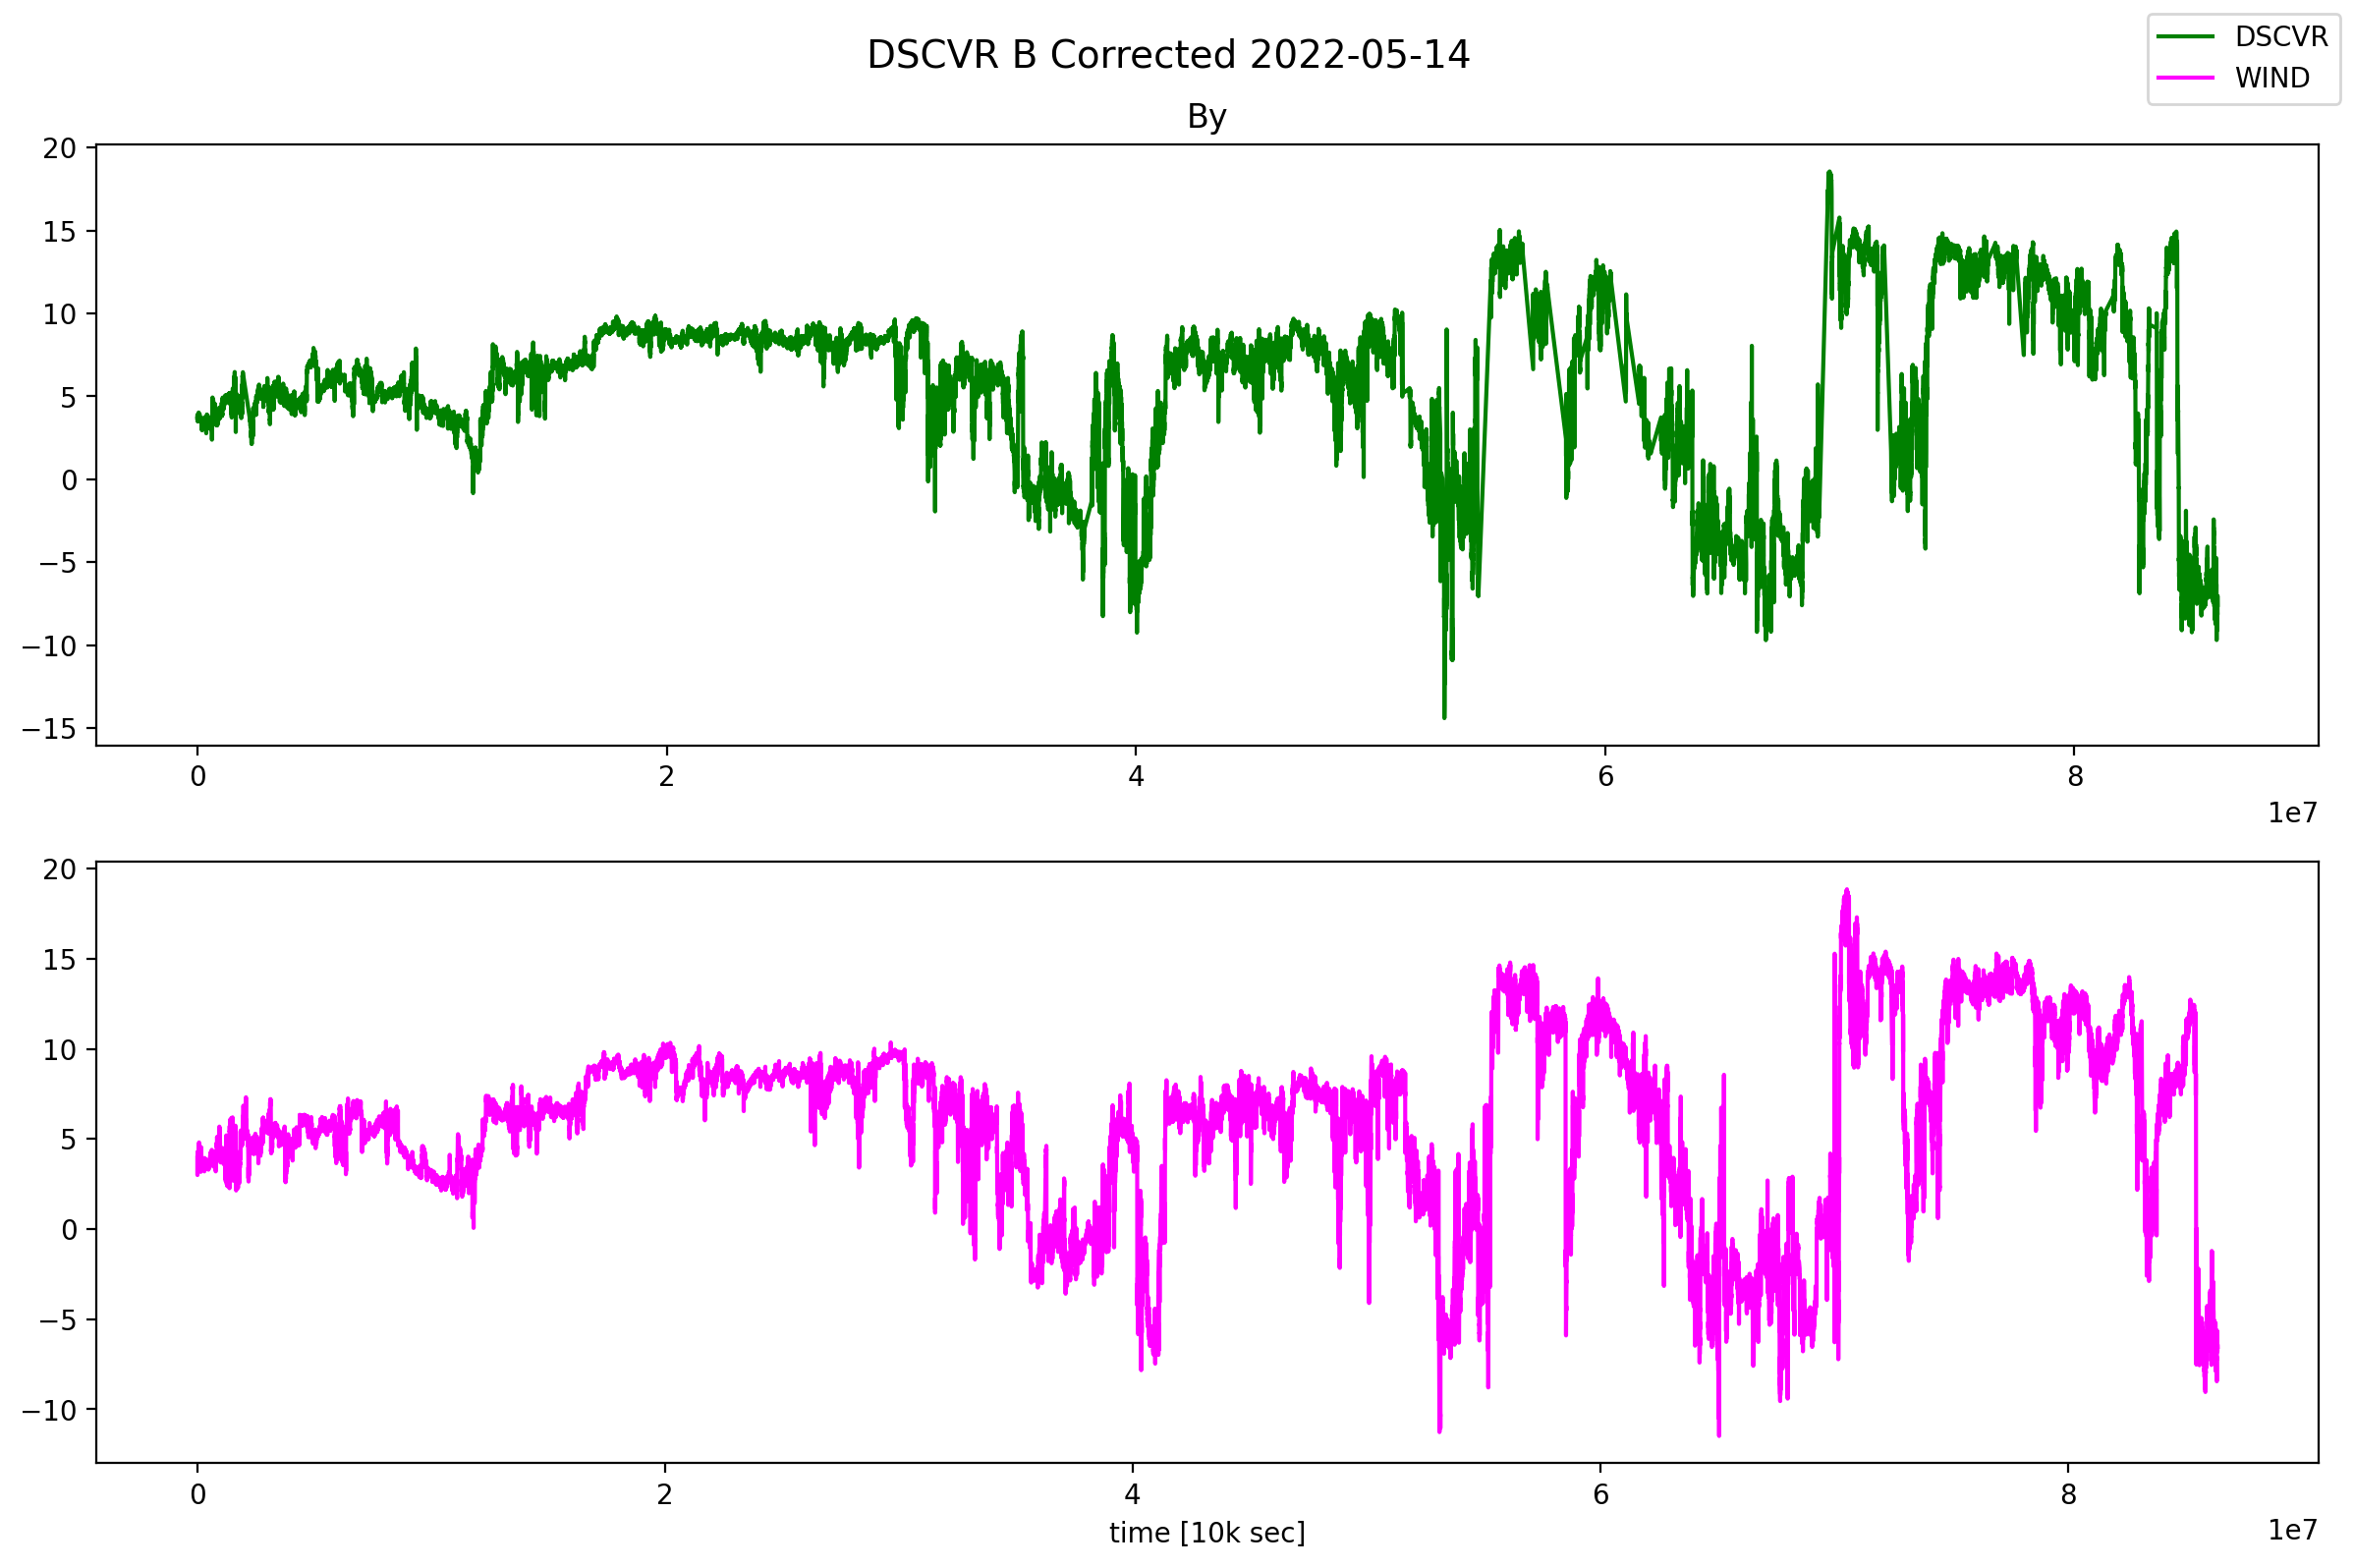

In [31]:
fig, axs = plt.subplots(2, 1)
title = 'DSCVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_by, = axs[0].plot(g_t[:,2], g_b[:,1], color=dsc_colour, label='By')

axs[0].set(title='By')
axs[1].set(xlabel='time [10k sec]')

w_by, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')

fig.legend([d_bx, w_bx], ['DSCVR', 'WIND'], loc='upper right')

plt.tight_layout()

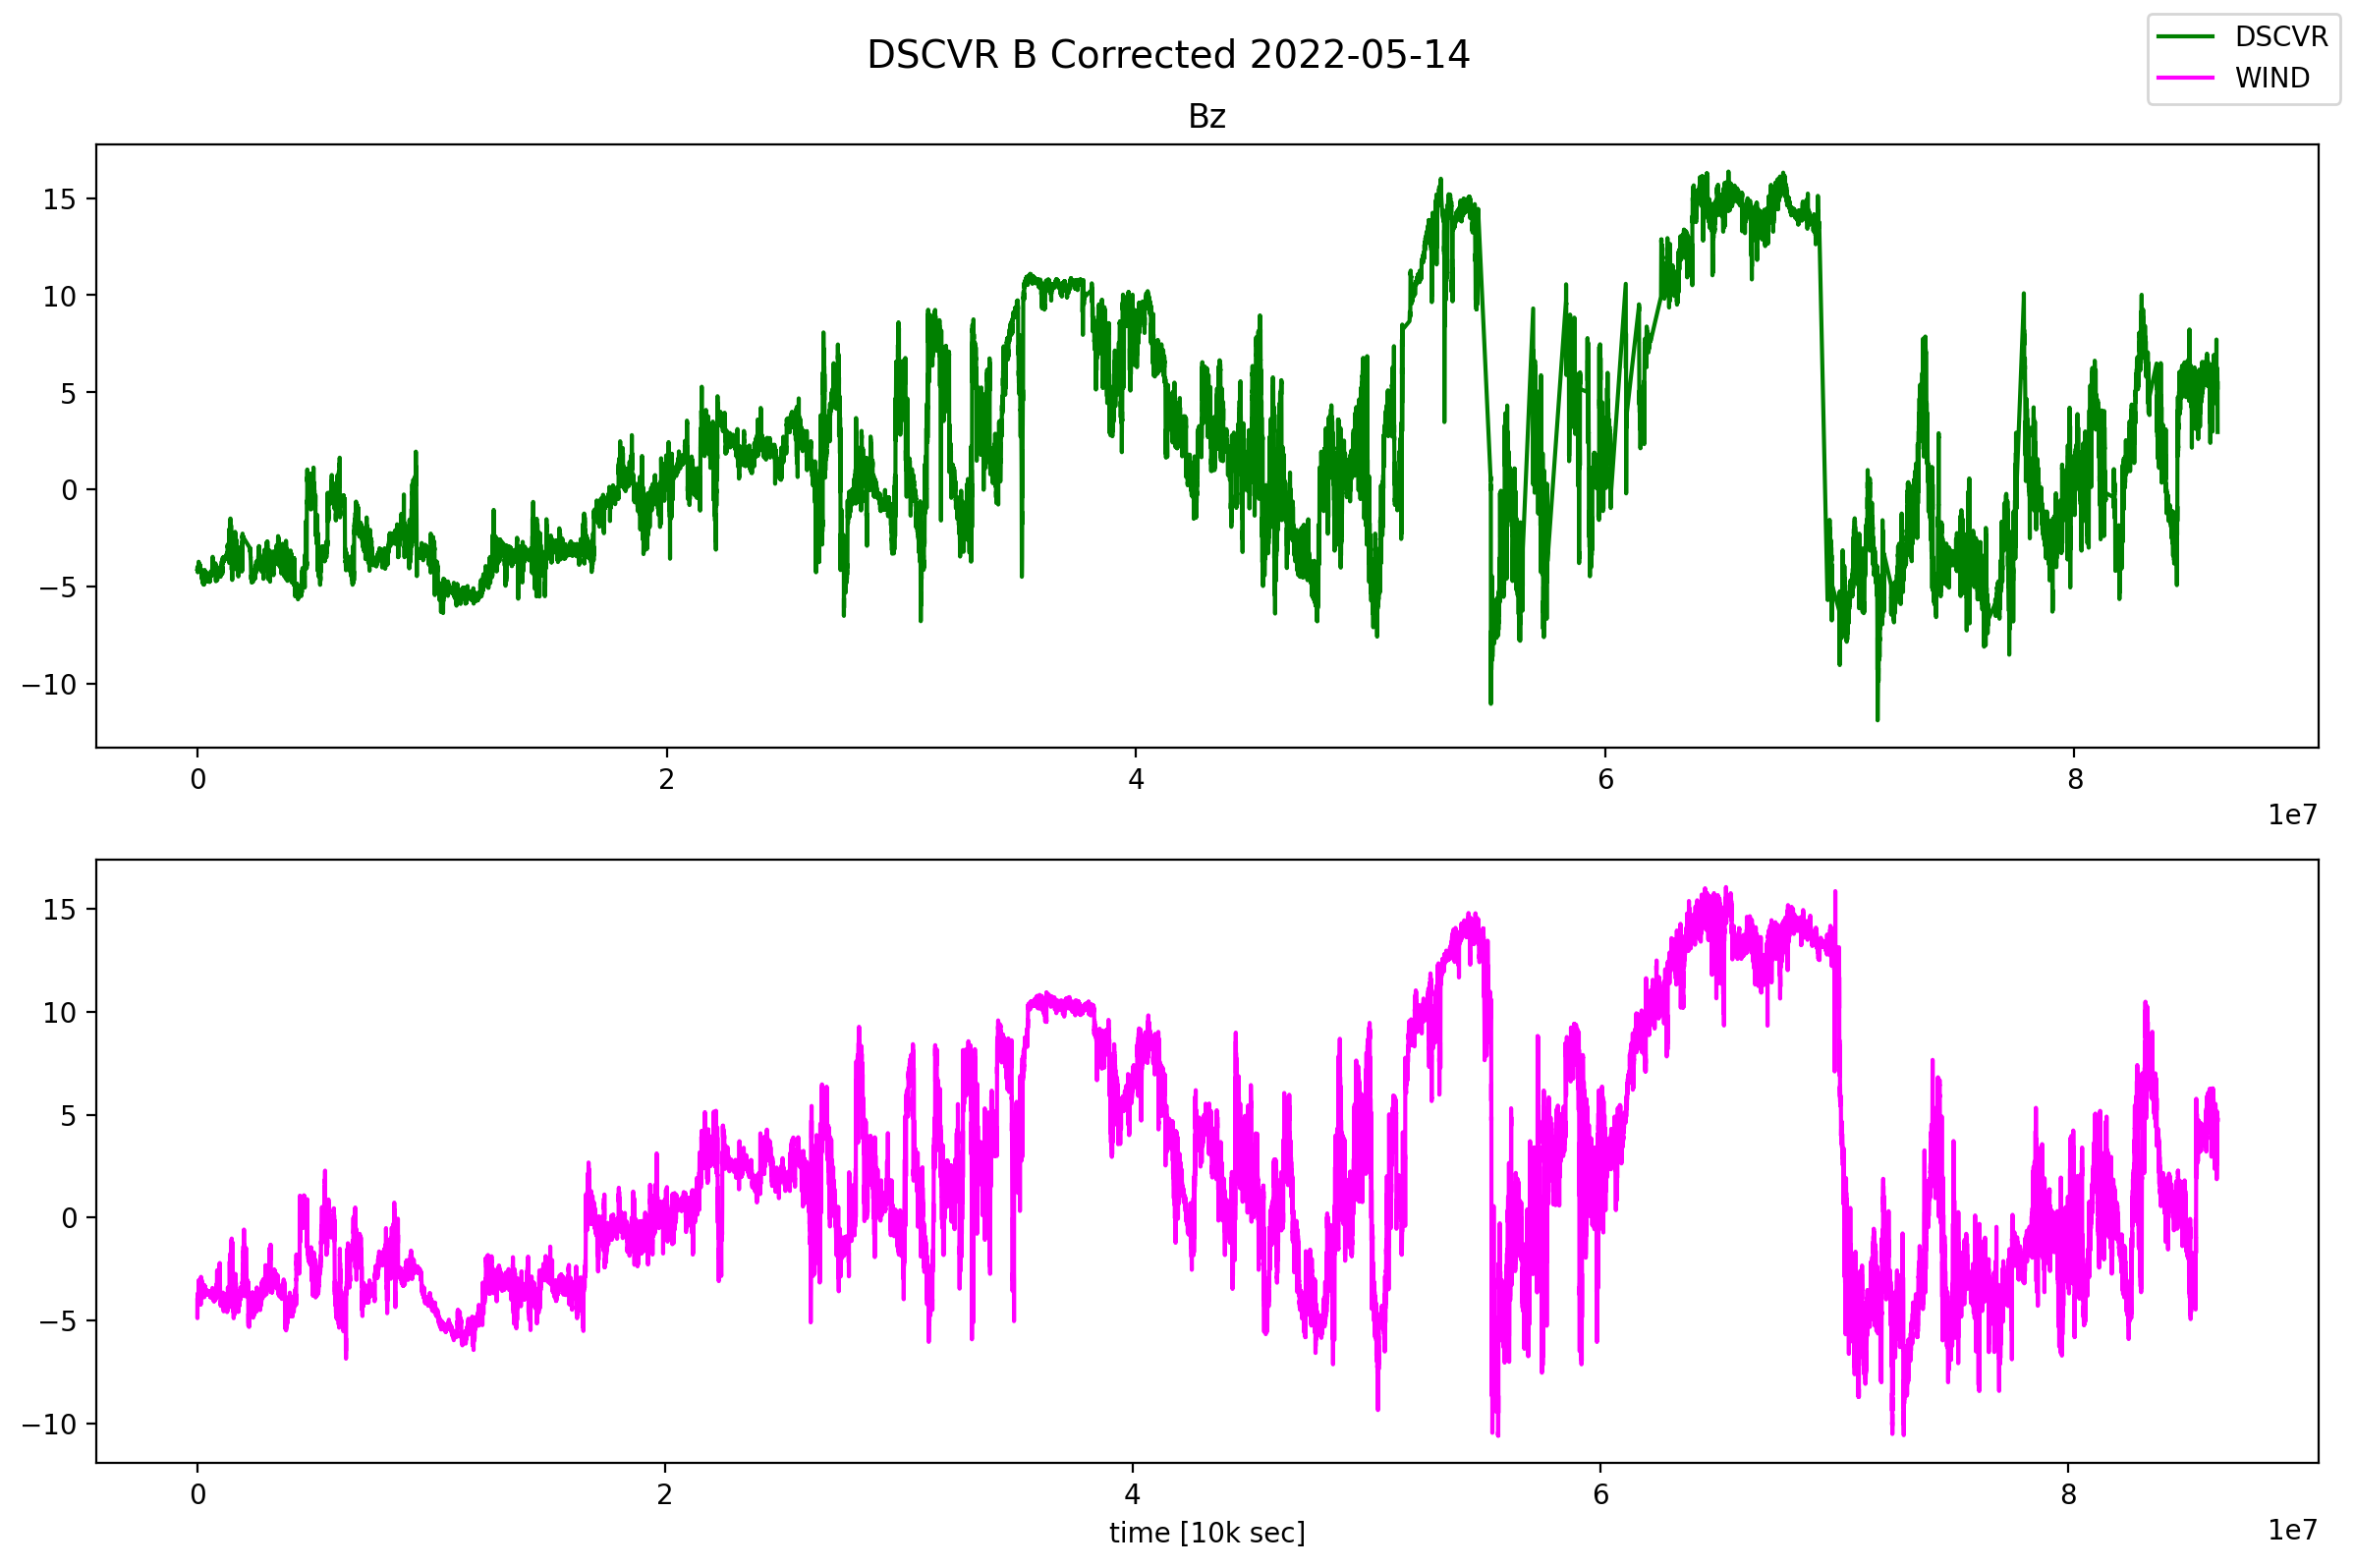

In [32]:
fig, axs = plt.subplots(2, 1)
title = 'DSCVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_bz, = axs[0].plot(g_t[:,2], g_b[:,2], color=dsc_colour, label='Bz')

axs[0].set(title='Bz')
axs[1].set(xlabel='time [10k sec]')

w_bz, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

fig.legend([d_bx, w_bx], ['DSCVR', 'WIND'], loc='upper right')

plt.tight_layout()